## OCNT-DMSLIB-1 DMS Assay Run #3: TYK2 IFN-alpha Gradient

This data represents the first sequencing run of what will be two total runs. It contains 24 samples in the following experimental design, with replicates in each sample group labeled `A` through `D`:

| ID | Condition | Dosage | Replicates
| --- | ----------- | --- | ----------- |
| 1 | IFN-beta | 100 | 4 |
| 2 | None | 0 | 4 |
| 3 | IFN-alpha | 1 | 4 |
| 4 | IFN-alpha | 10 | 4 |
| 5 | IFN-alpha | 100 | 4 |
| 6 | IFN-alpha + Drug | 100 + Drug | 4 |

Let's check some effects we expect to observe (mainly QC parameters and stop codons), then examine the global distribution of mutant vs WT effects across conditions.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Gain-of-Function](#part4)
5. [Spike-Ins](#part5)
6. [Positionwise Aggregation](#part6)


In [15]:
library(magrittr)
library(data.table)
library(ggpubr)
library(ggrepel)
library(vroom)
library(scales)
library(UpSetR)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(glmmTMB)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

### Barcode Sequencing Distributions <a name="part1"></a>

In most samples, we just miss the desired 30 barcodes per sample (though the medians are generally pretty close).There is also substantial dropout in chunk 16, with only about 31% of those variants making it through. Otherwise, most amino acid level variants have a median 24 unique barcode per residue.

In [7]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run3/combined/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "lib", "chunk",
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "condition", "condition_conc","clone", "count")) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

Rows: 19517230 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): sample, barcode, lib, chunk, wt_aa, mut_aa, wt_codon, mut_codon, d...
dbl  (4): pos, condition_conc, clone, count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

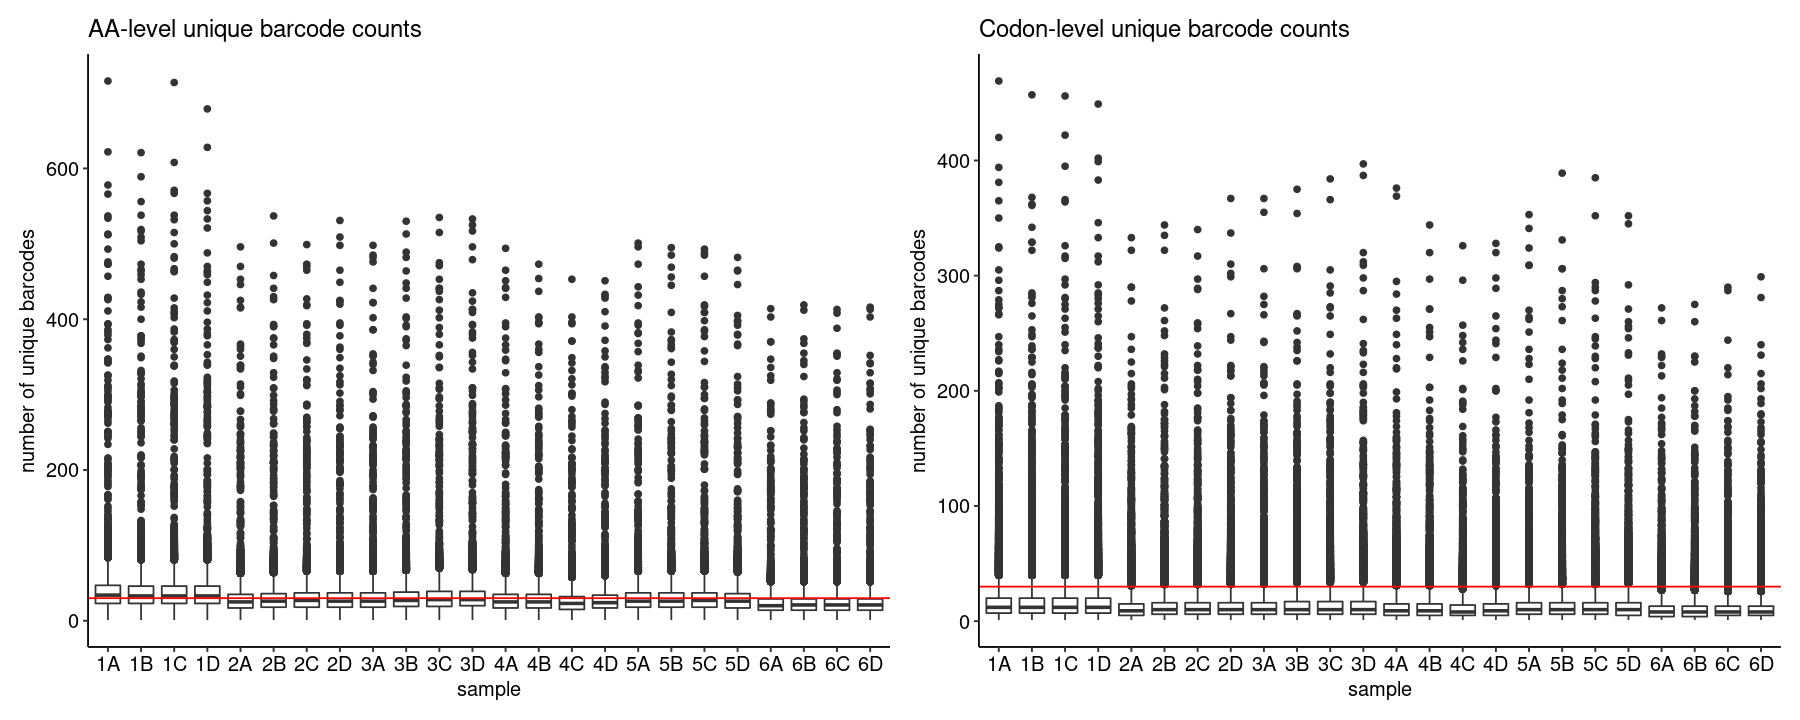

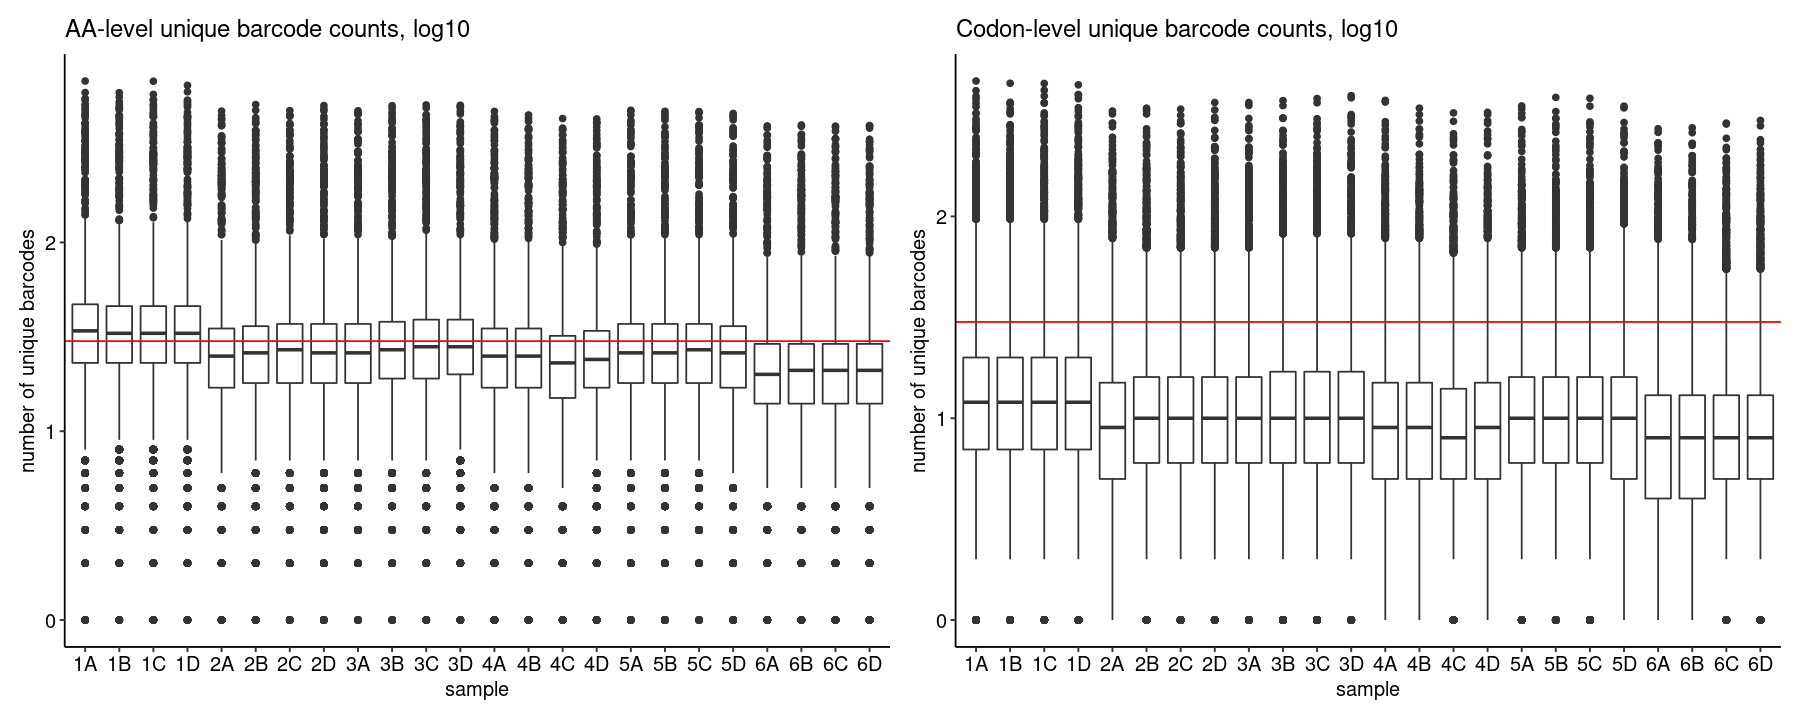

In [10]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using sample `1A` only; the remaining plots can be found [here](./coverage-plots):

In [12]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-1-assay-run3-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

In [13]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_

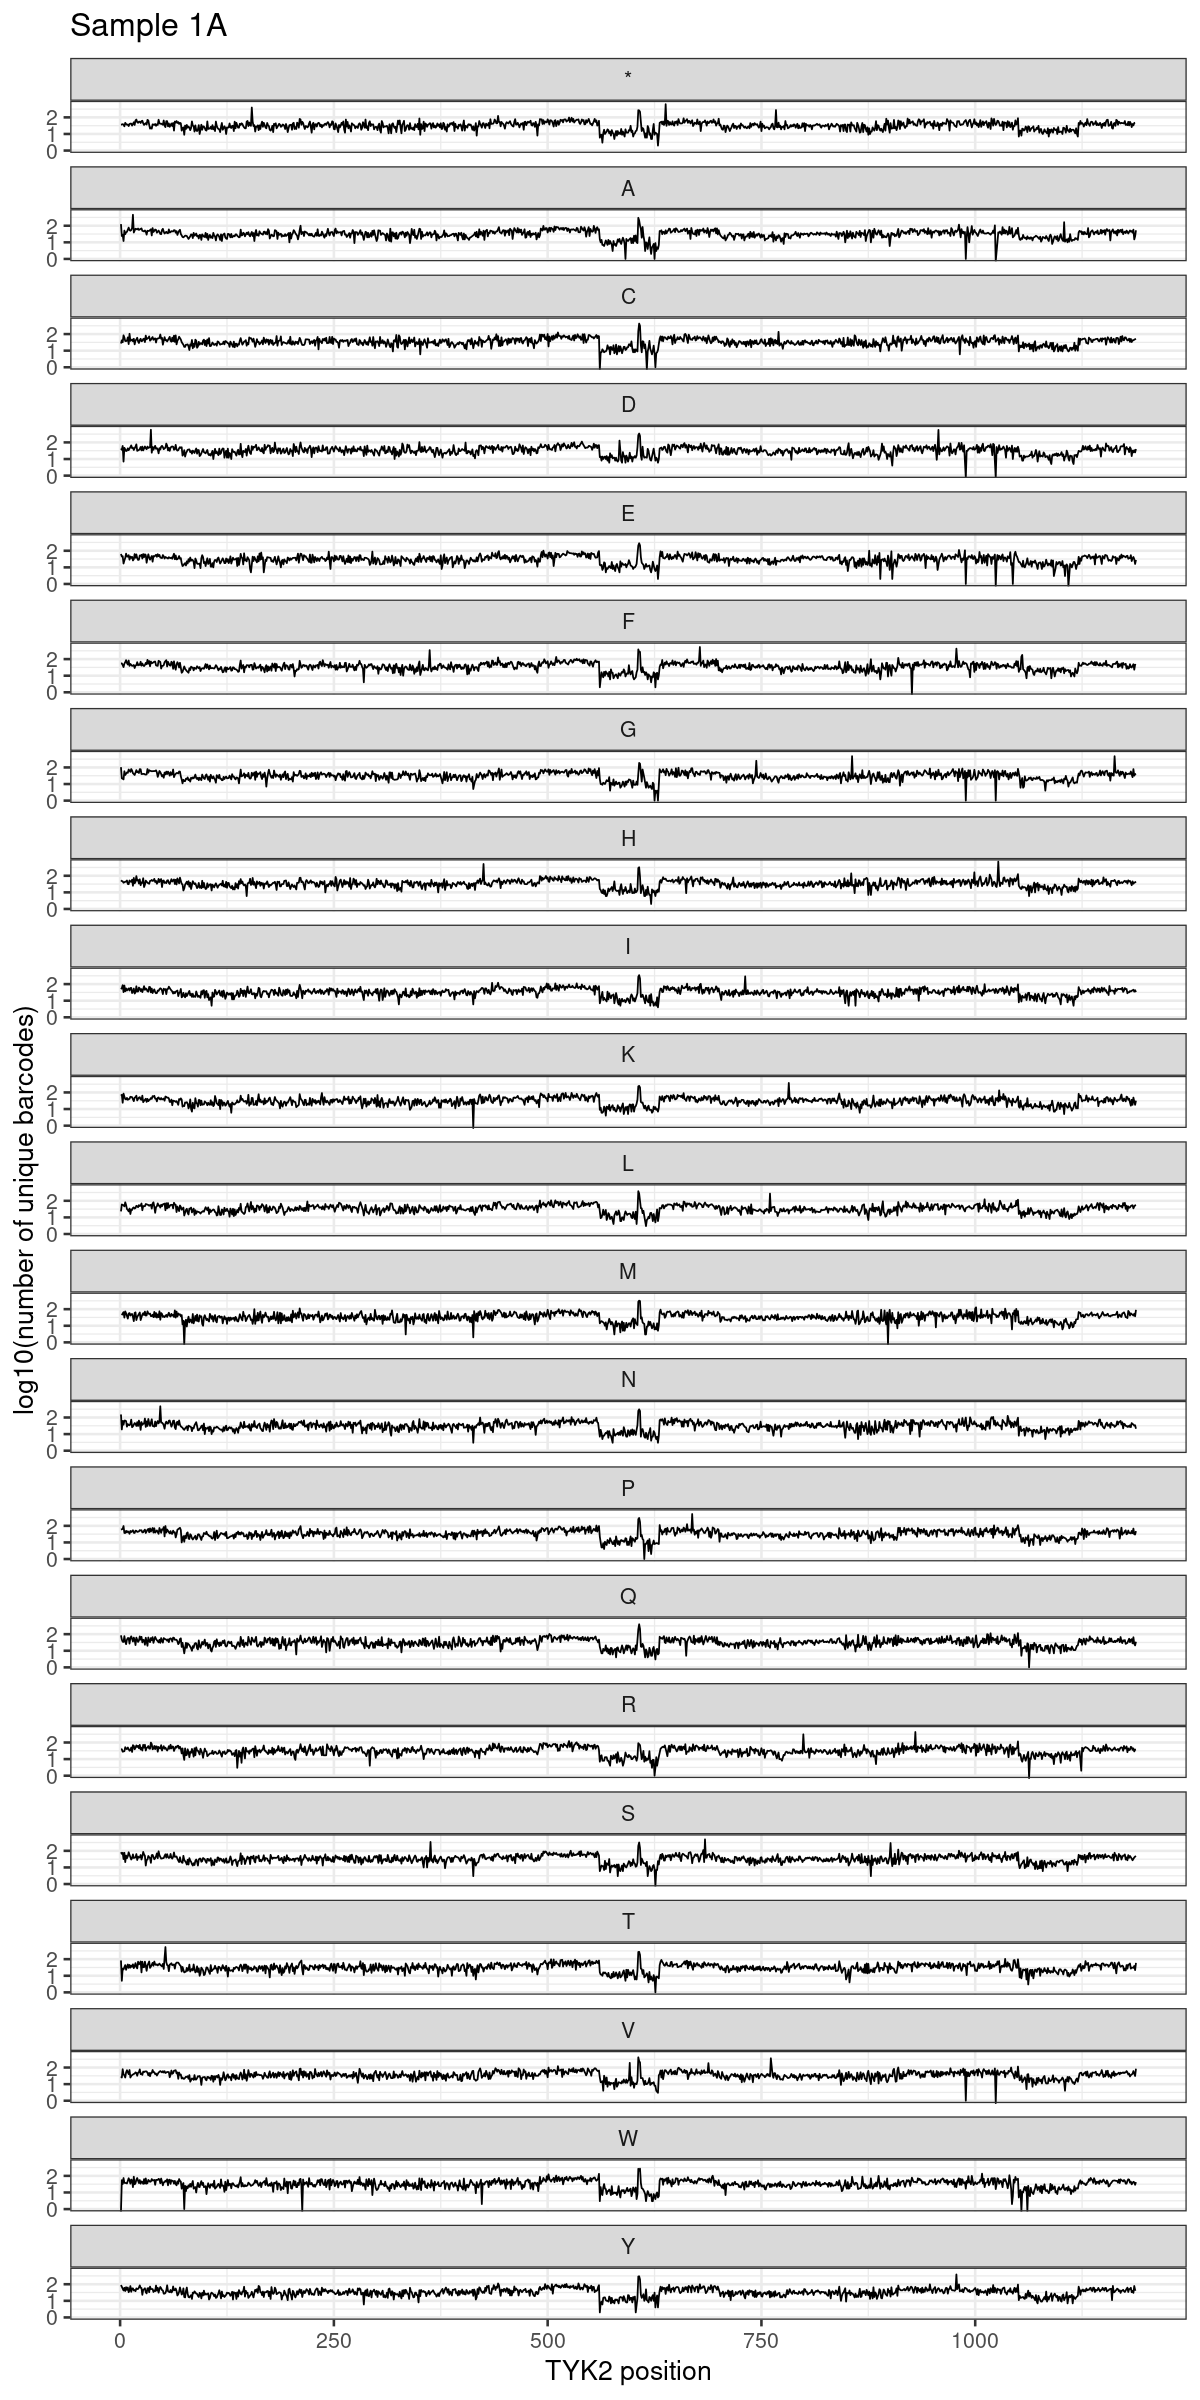

In [14]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

Finally, we can count up the number of unique barcodes per chunk per sample, and observe that the relative proportions are highly consistent across replicate groups:

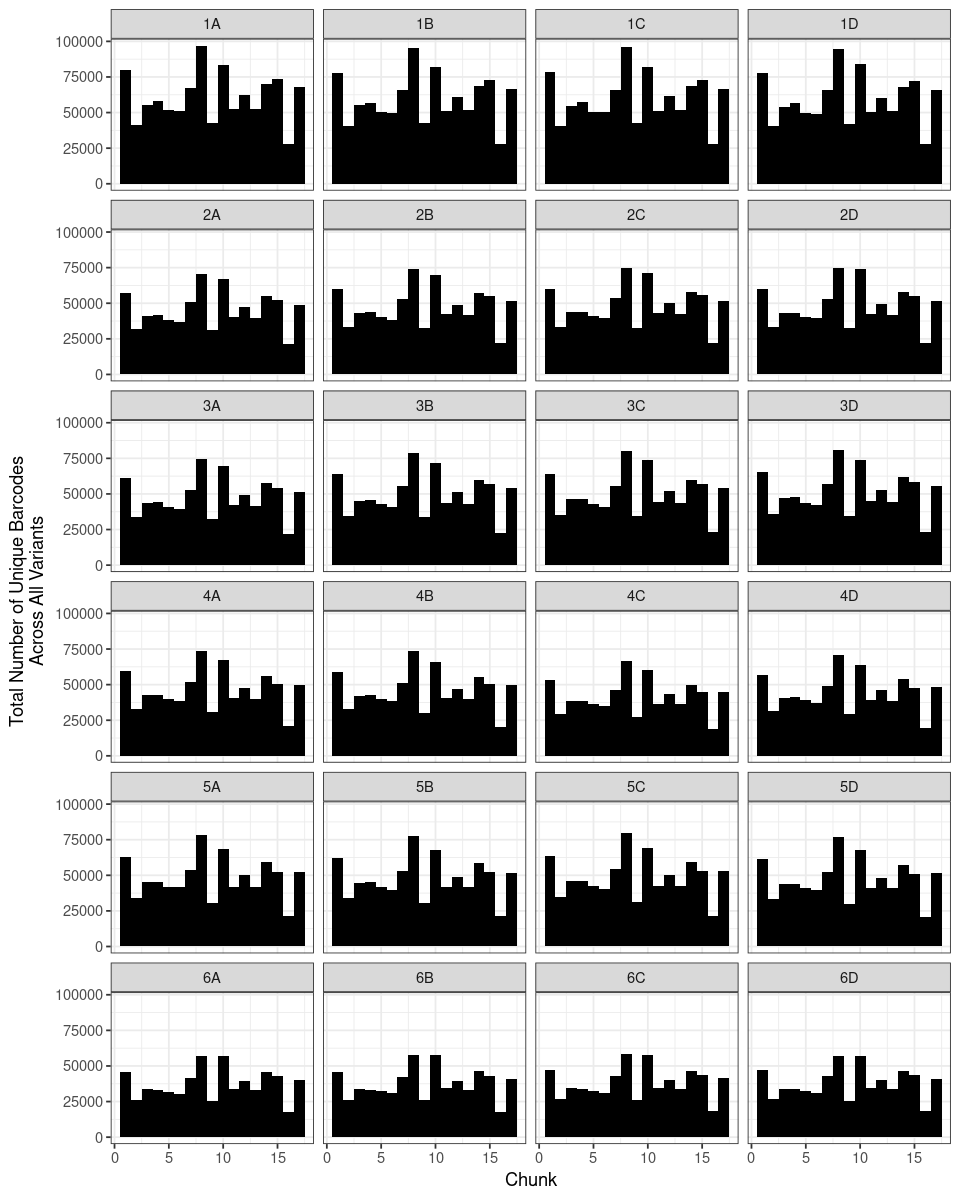

In [11]:
options(repr.plot.width = 8, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = if_else(chunk == "12rc", "12", chunk),
           chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

Or, if we add all chunks together and just get the total number of unique barcodes per sample, we generally hover around 650,000 or so:

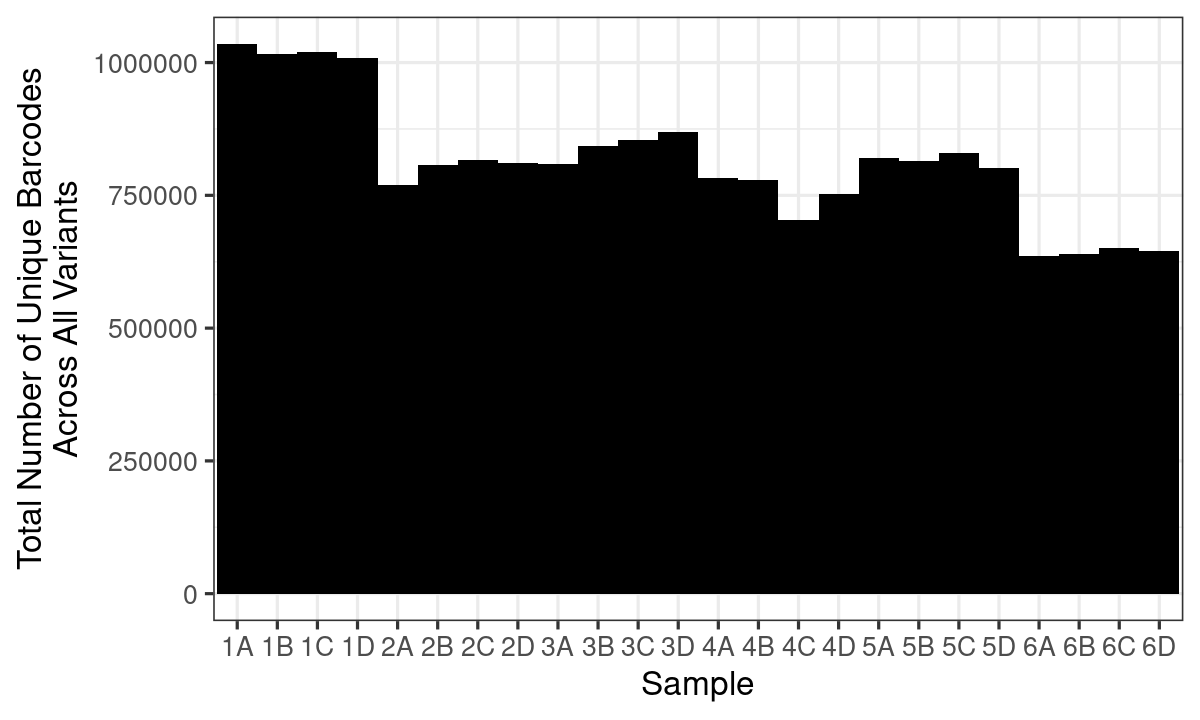

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

We'll normalize each condition to either IFN-beta or None using the summary statistics, and show results for both. Our usual starting point is asking whether we observe the expected, significantly negative stop codon effects. The easiest way to show this, while allowing for some chunk specificity, is to plot the density of Z-statistics for all non-stop variants in all chunks in each condition, but separate the stop variant distributions by chunk. 

In [3]:
sumstats <- dir_ls(path = "../sumstats/TYK2/run3/", regexp = "tyk2_.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    select(-group) %>%
    write_tsv("../sumstats/TYK2/run3/tyk2-assay3-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

In [4]:
compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None0")
ifnbIdx <- which(conditions == "IFNbeta100")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0")))
sumstats_ifnb_contr <- map_dfr(conditions[-ifnbIdx],
                         ~compute_difference(test = .,
                                            control = "IFNbeta100",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100")))

sumstats_all <- bind_rows(sumstats_none_contr, sumstats_ifnb_contr) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_all %>% write_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv")

In [9]:
sumstats_all %>%
    filter(condition == "IFNalpha100 - None0") %>%
    select(-clone, -dispersion, -version) %>%
    relocate(condition, .after = p.adj) %>%
    rename("Position" = "pos",
           "Chunk" = "chunk",
           "AA" = "aa",
           "Log2FoldChange" = "estimate",
           "StandardError" = "std.error",
           "Statistic" = "statistic",
           "Pvalue" = "p.value",
           "Padj" = "p.adj",
           "Comparison" = "condition") %>%
    write_tsv("../sumstats/TYK2/BMS/IFNalpha100_vs_Untreated.tsv")

sumstats_all %>%
    filter(condition == "IFNalpha100 - IFNbeta100") %>%
    select(-clone, -dispersion, -version) %>%
    relocate(condition, .after = p.adj) %>%
    rename("Position" = "pos",
           "Chunk" = "chunk",
           "AA" = "aa",
           "Log2FoldChange" = "estimate",
           "StandardError" = "std.error",
           "Statistic" = "statistic",
           "Pvalue" = "p.value",
           "Padj" = "p.adj",
           "Comparison" = "condition") %>%
    write_tsv("../sumstats/TYK2/BMS/IFNalpha100_vs_IFNbeta100.tsv")

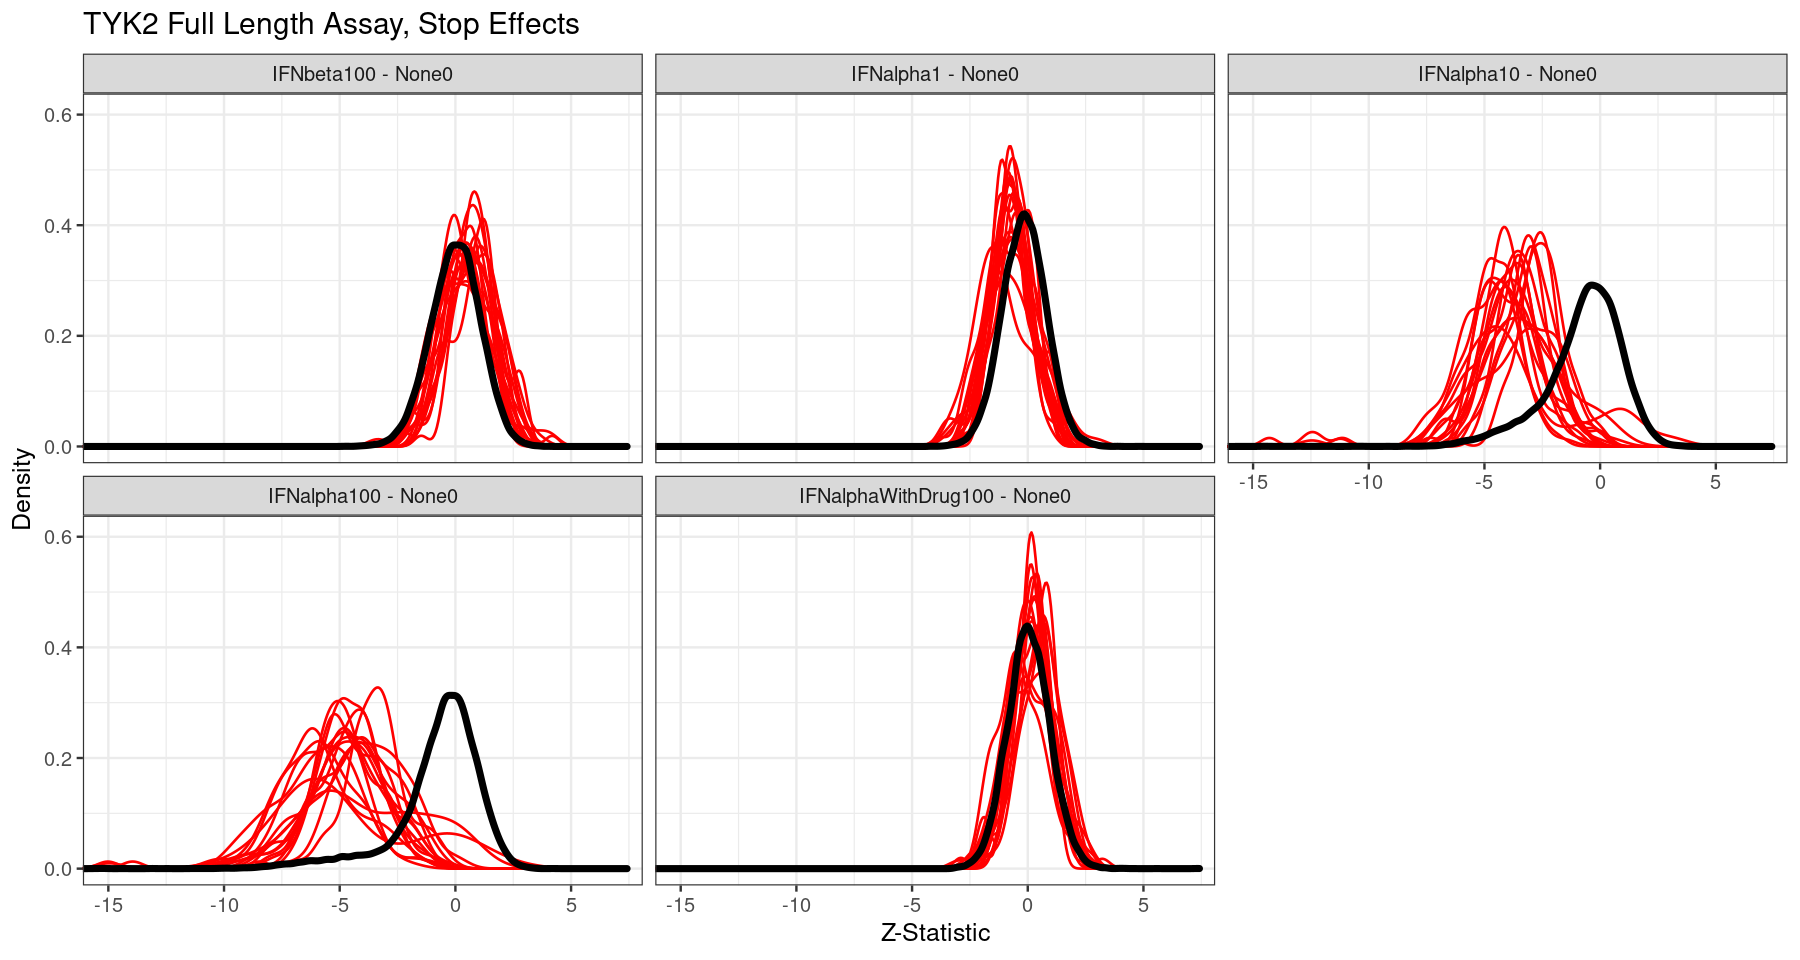

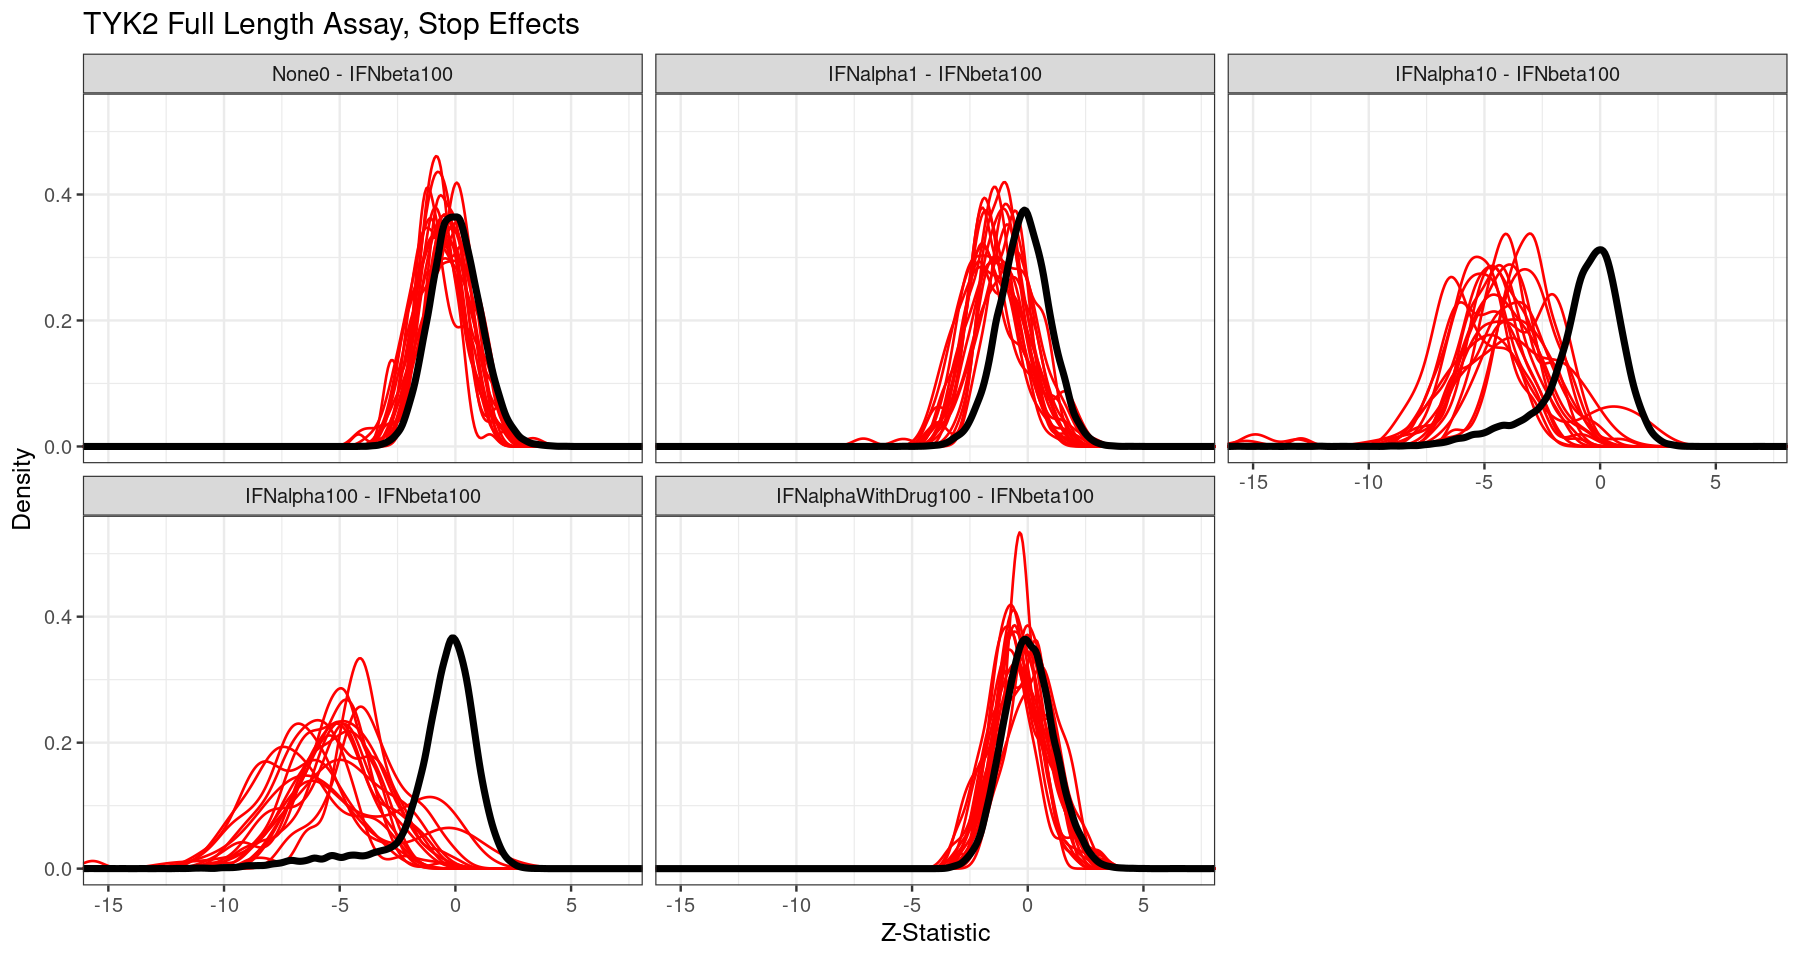

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8)
sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~condition, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

sumstats_all %>%
    filter(grepl("- IFNbeta100", condition)) %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~condition, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [7]:
sumstats_all %>%
    count(condition, sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n) %>%
    kable(type = "markdown")



|condition                        | Non-Significant| Significant (FDR < 0.01)|
|:--------------------------------|---------------:|------------------------:|
|IFNbeta100 - None0               |           23677|                       46|
|IFNalpha1 - None0                |           23706|                       17|
|IFNalpha10 - None0               |           21524|                     2199|
|IFNalpha100 - None0              |           21076|                     2647|
|IFNalphaWithDrug100 - None0      |           23713|                       10|
|None0 - IFNbeta100               |           23677|                       46|
|IFNalpha1 - IFNbeta100           |           23620|                      103|
|IFNalpha10 - IFNbeta100          |           21129|                     2594|
|IFNalpha100 - IFNbeta100         |           20904|                     2819|
|IFNalphaWithDrug100 - IFNbeta100 |           23680|                       43|

### Visualizations <a name="part4"></a>

Heatmaps and volcano plots are very efficient ways to take in the landscape of these data. In these heatmaps, the color scale is constant across all facets and the plotted values include the log2FoldChange and the Z-Statistic. The scale is unrestricted - in both plot sets, it was allowed to take on the most extreme values which existed in the data. Note how some regions have clearly a noisier baseline, and so stick out in the log2FoldChange heatmap, but which is correctly accounted for and thus flat in the Z-Statistic heatmap.

In [3]:
sumstats_all <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv")

Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


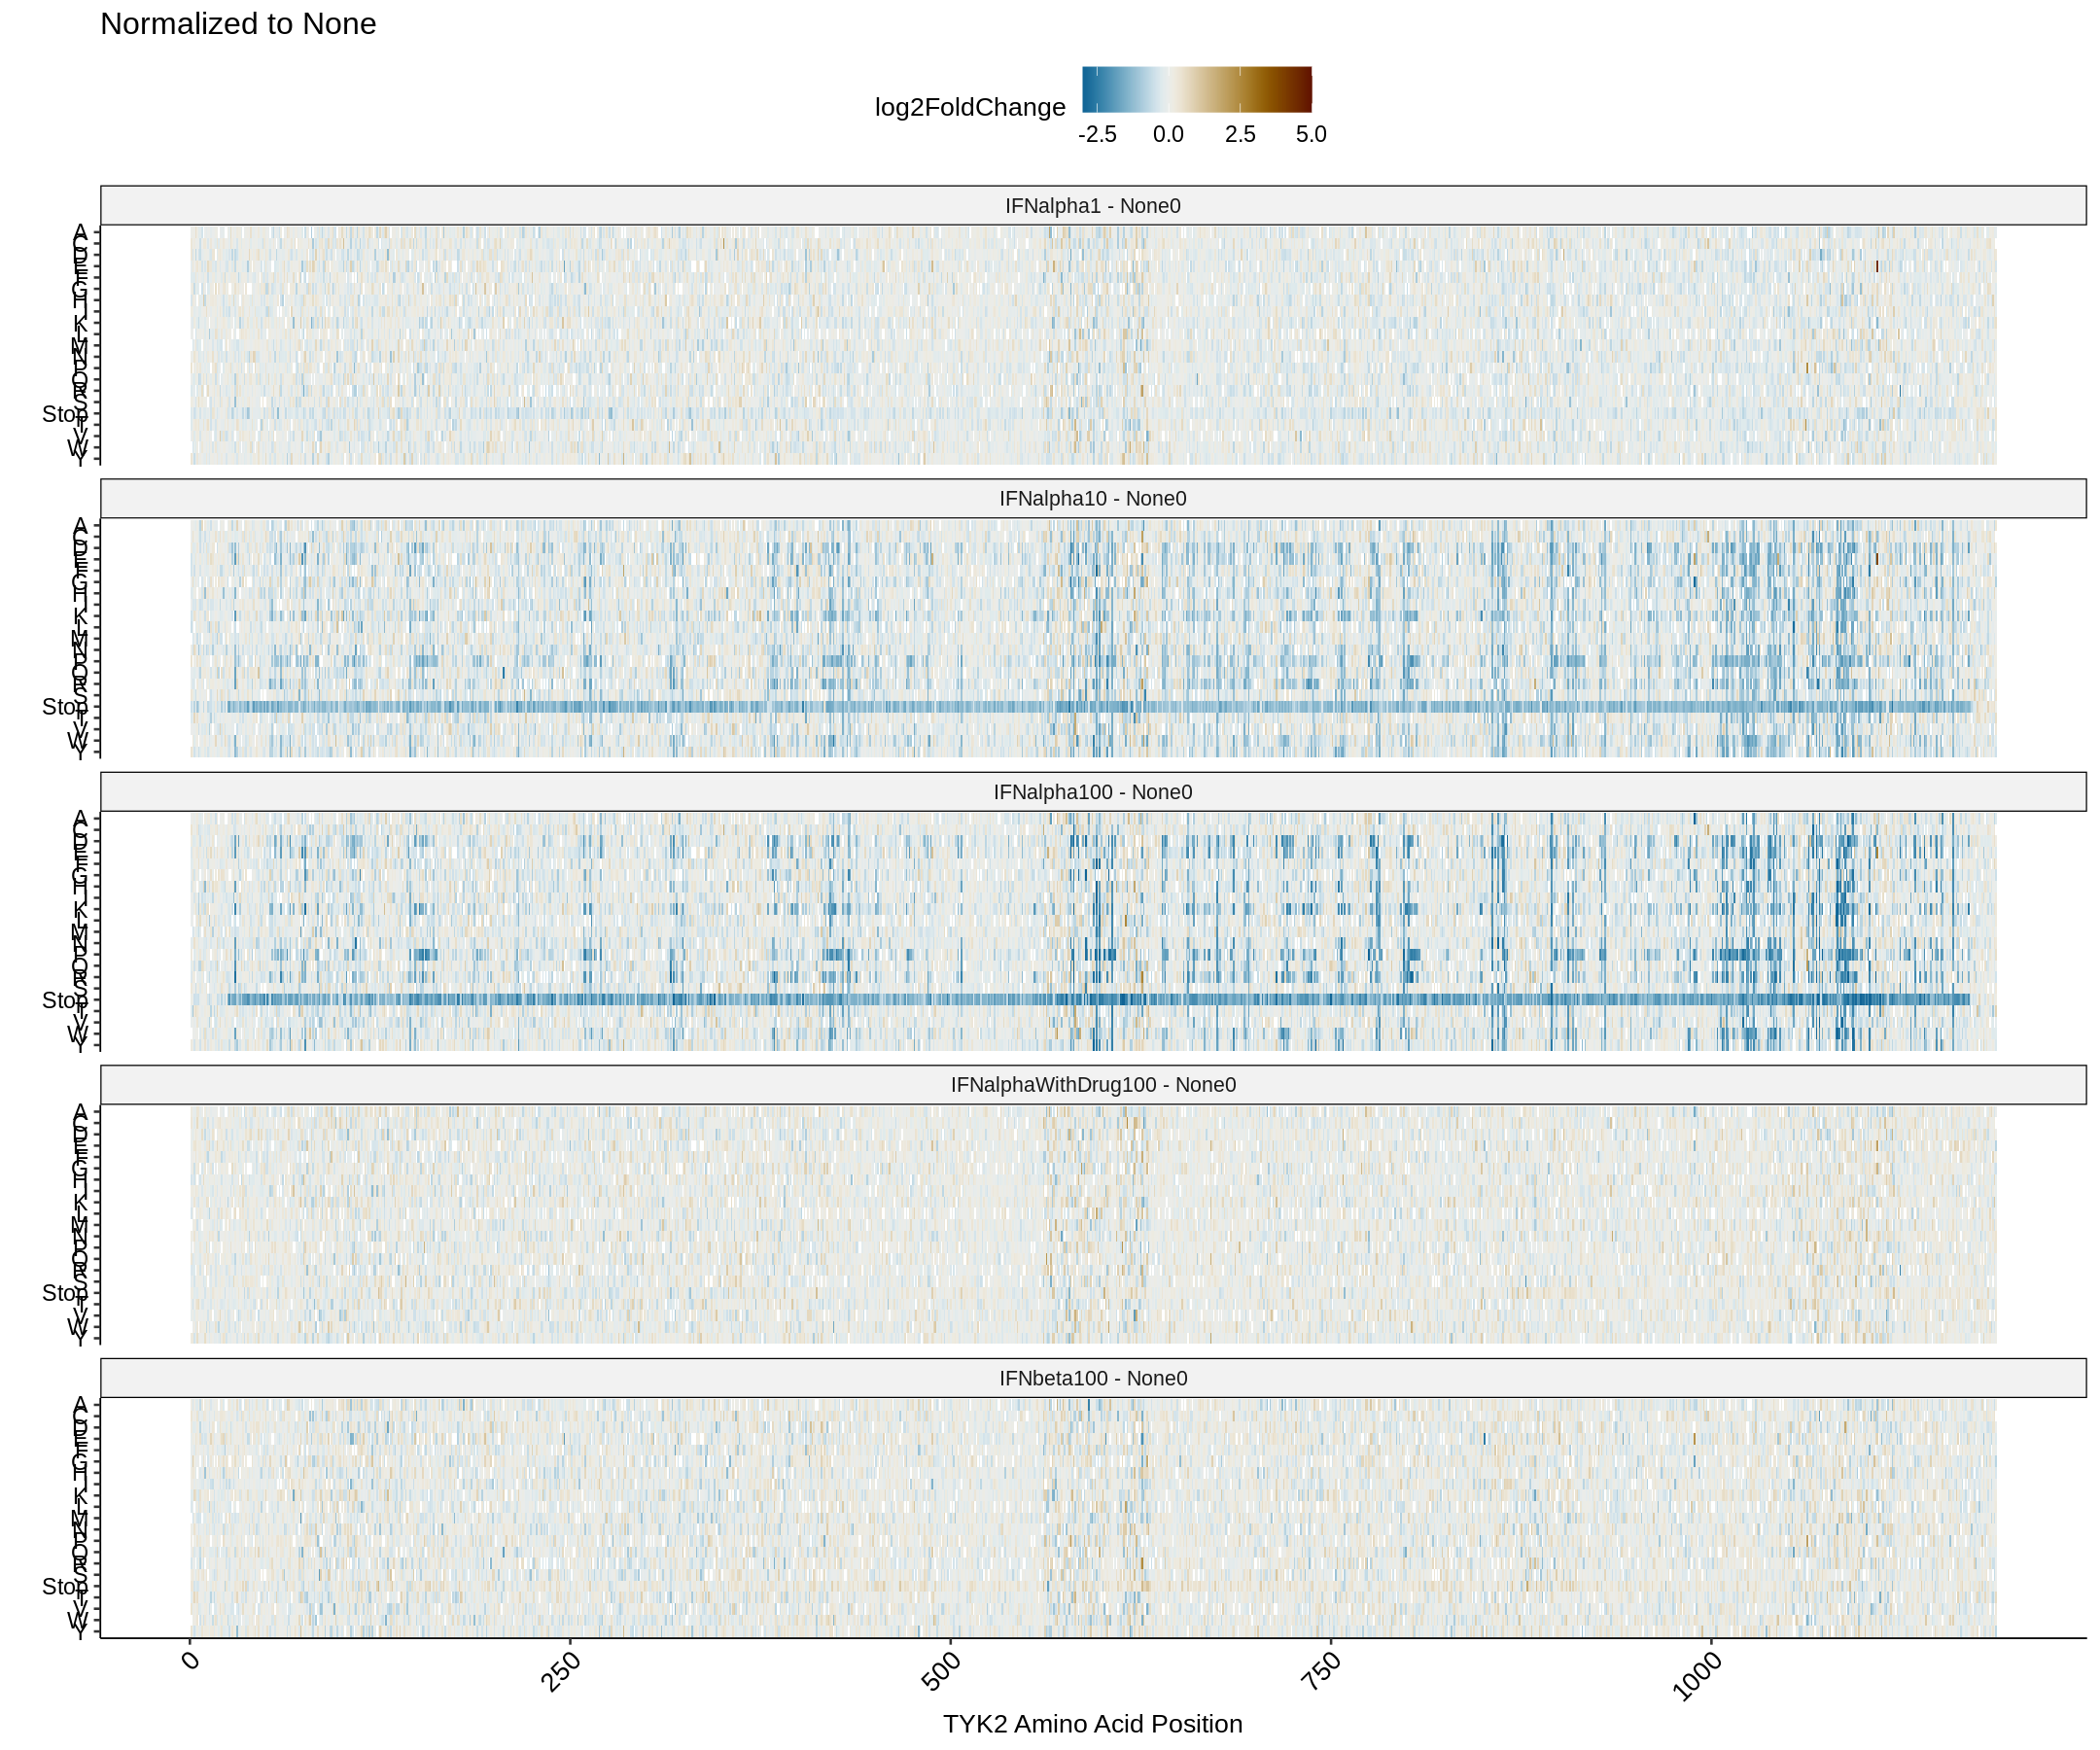

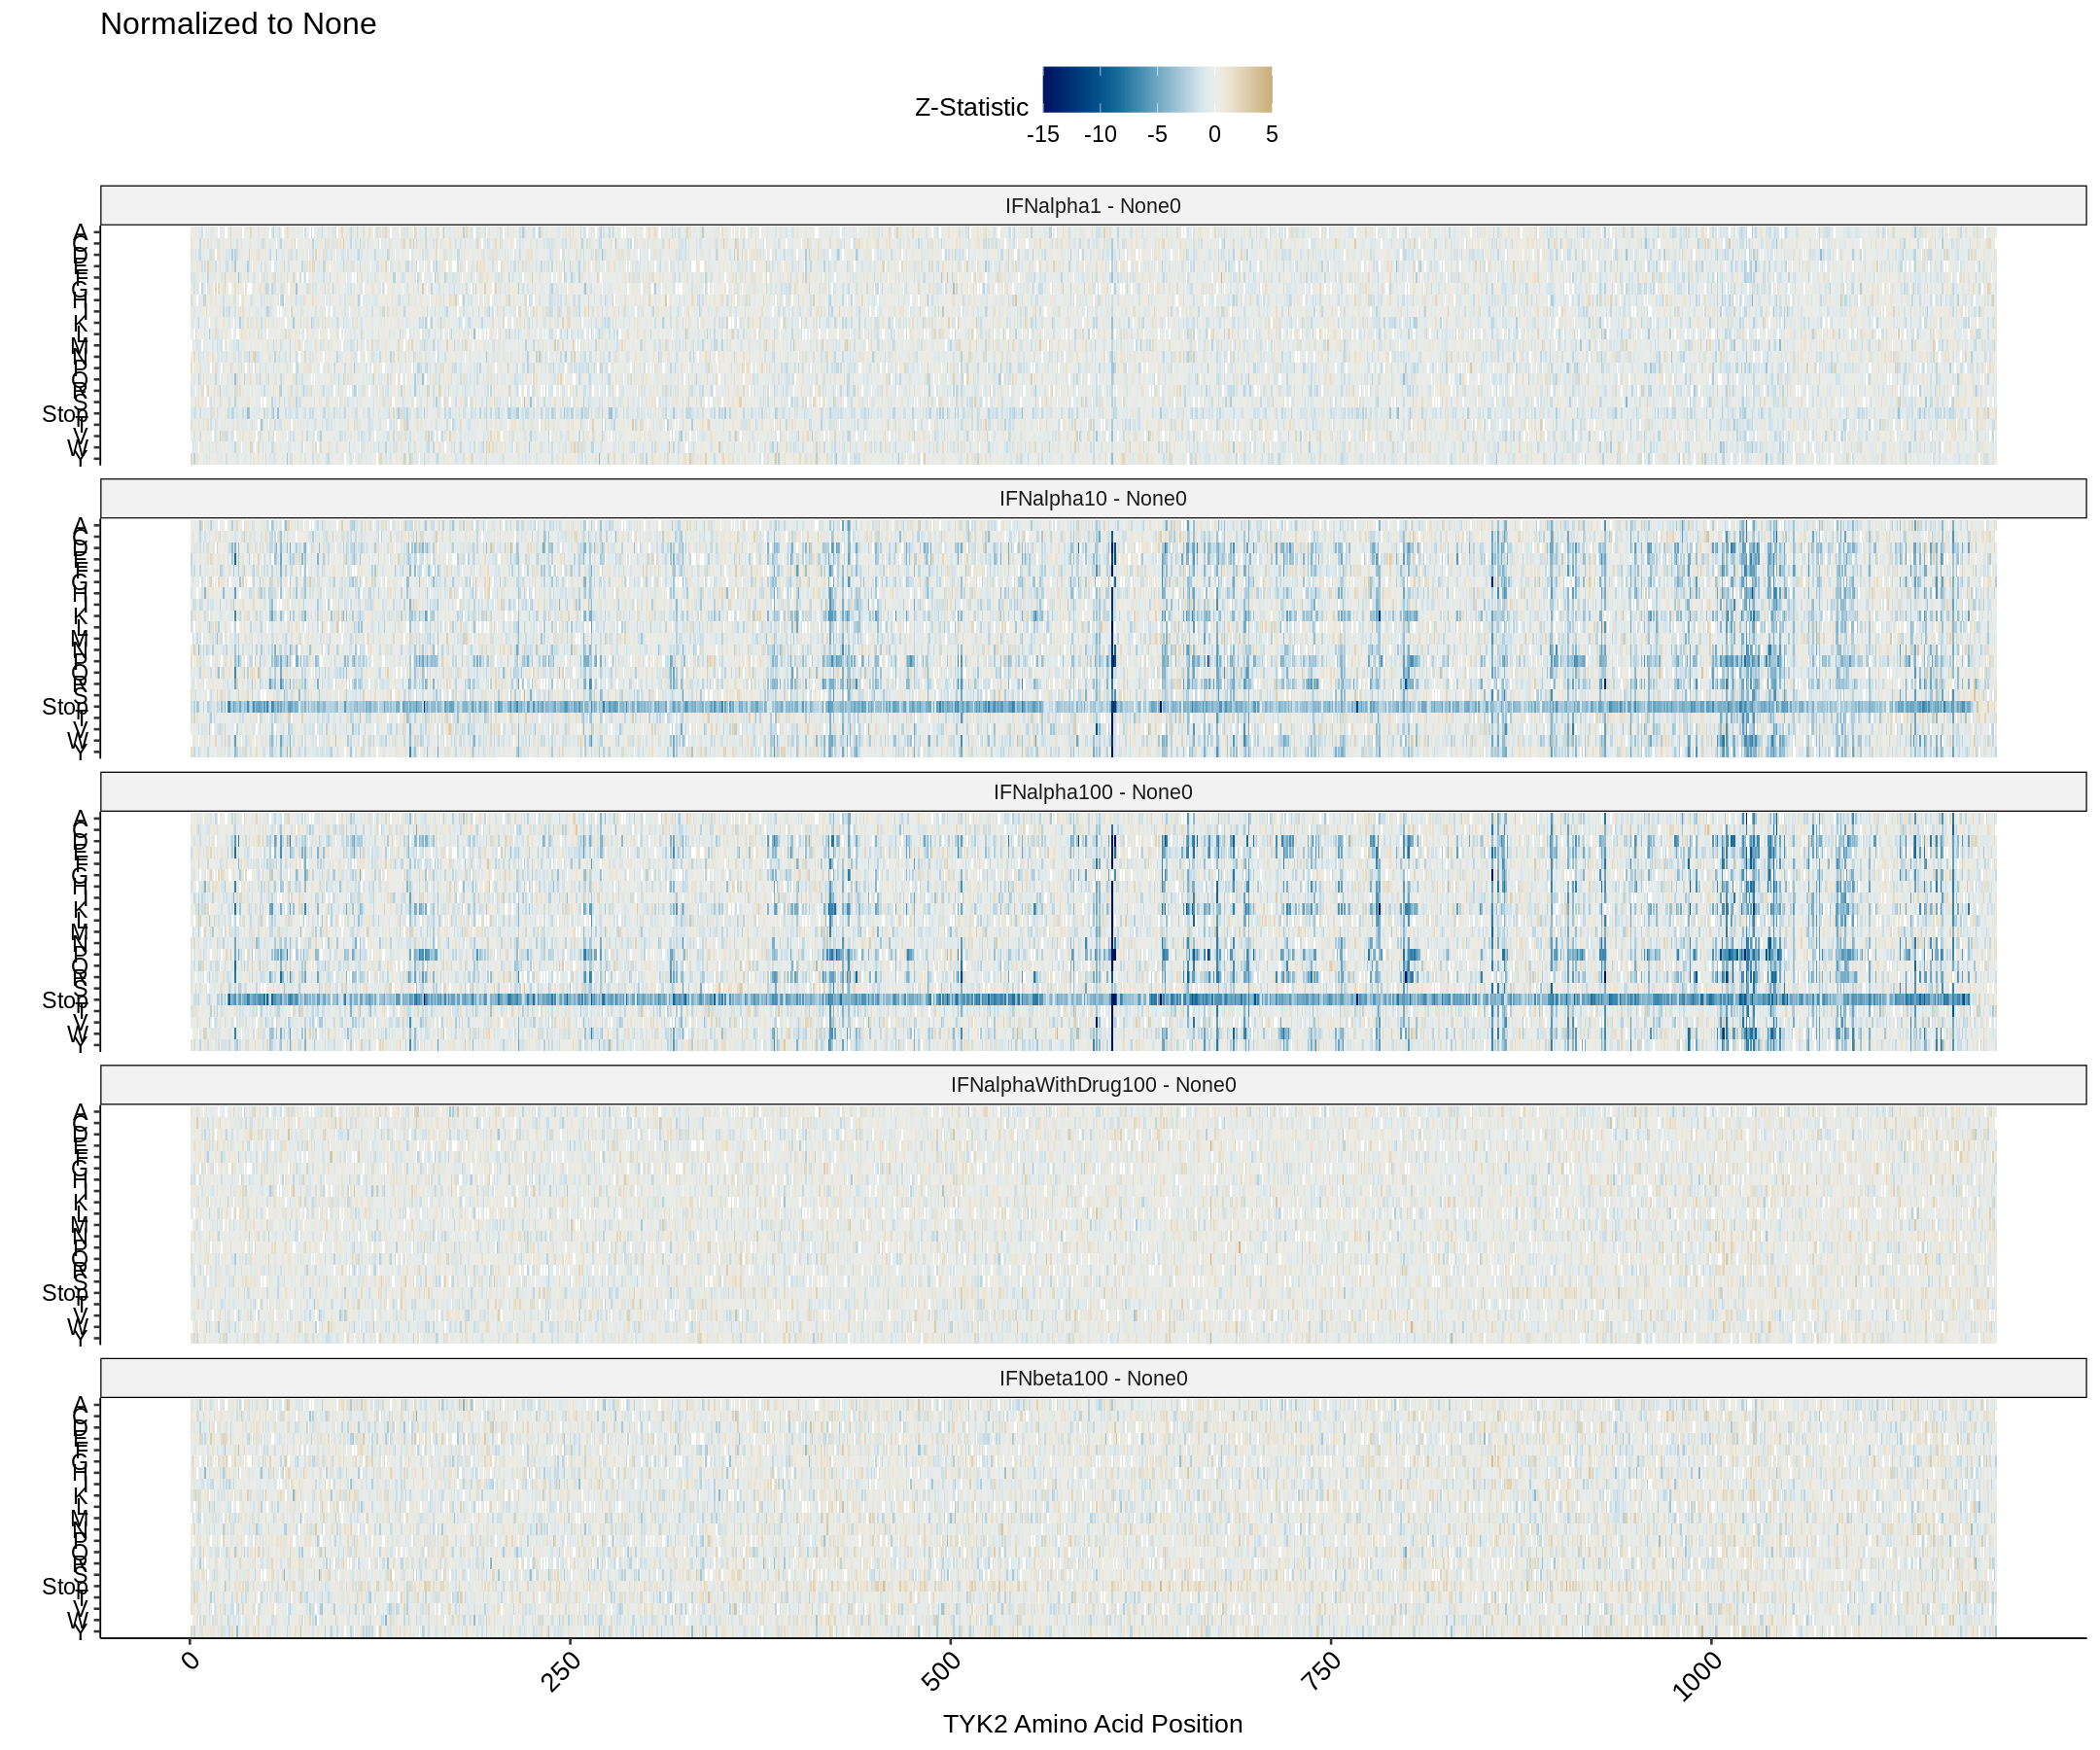

In [42]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

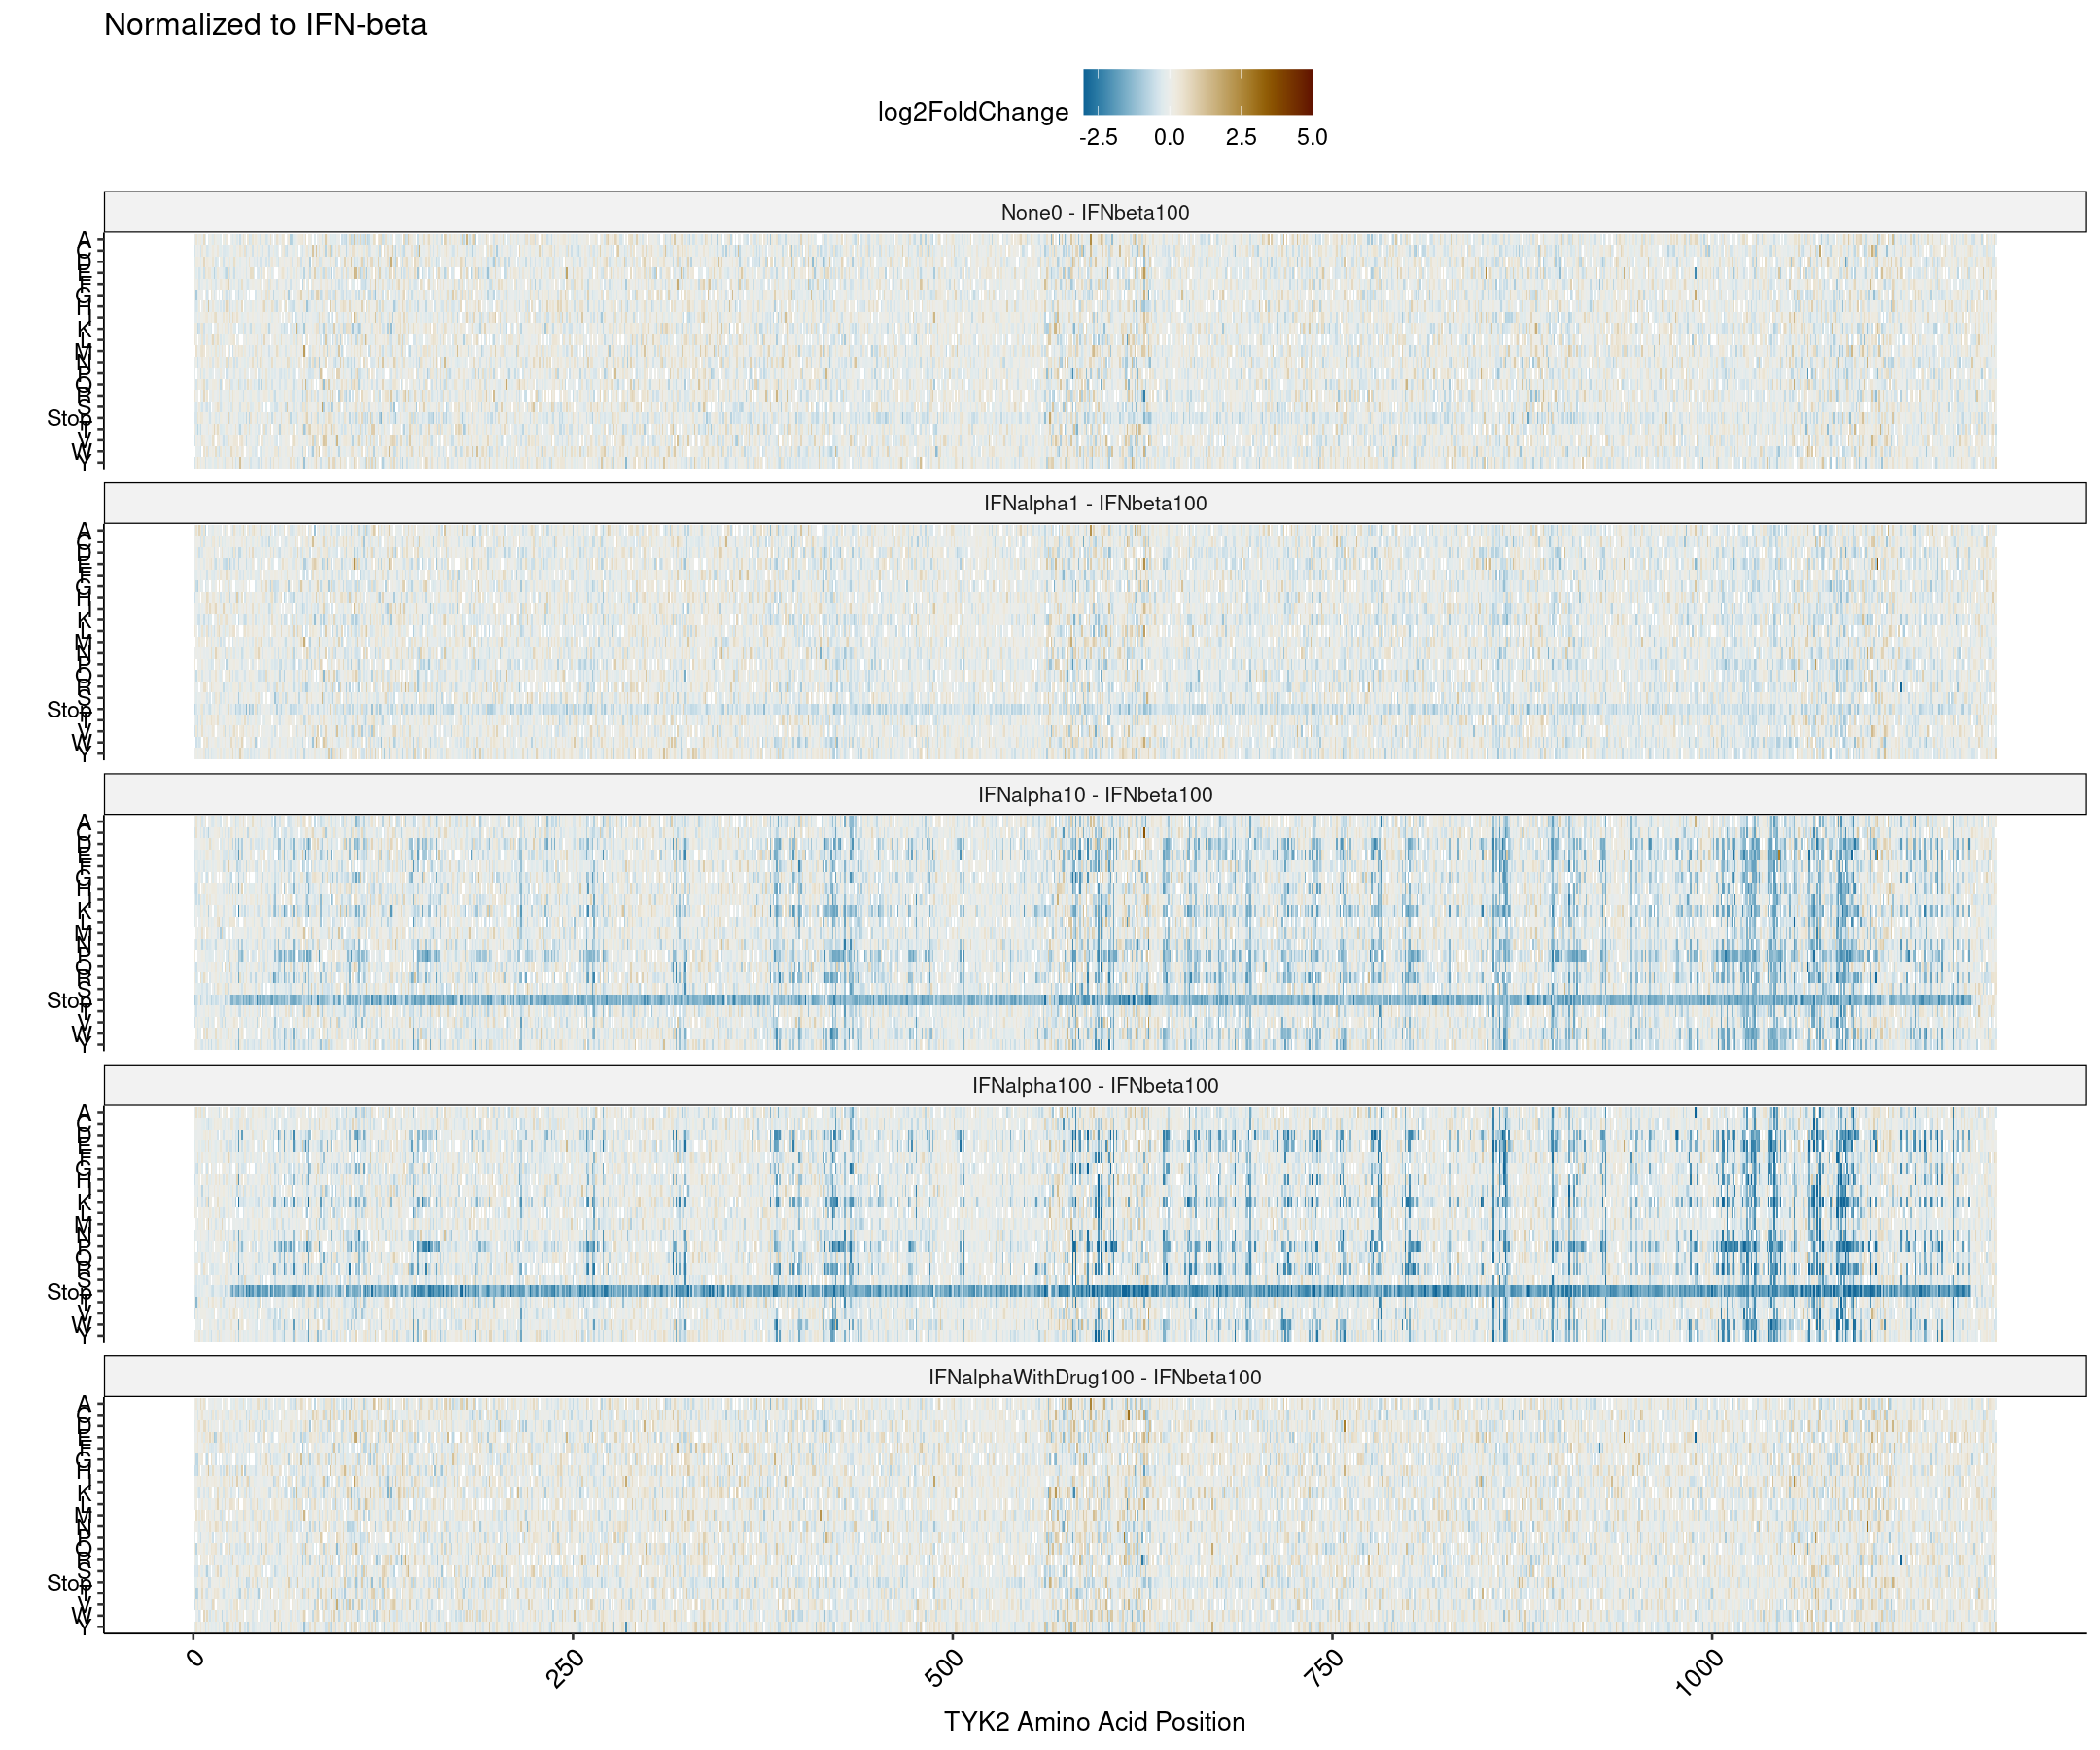

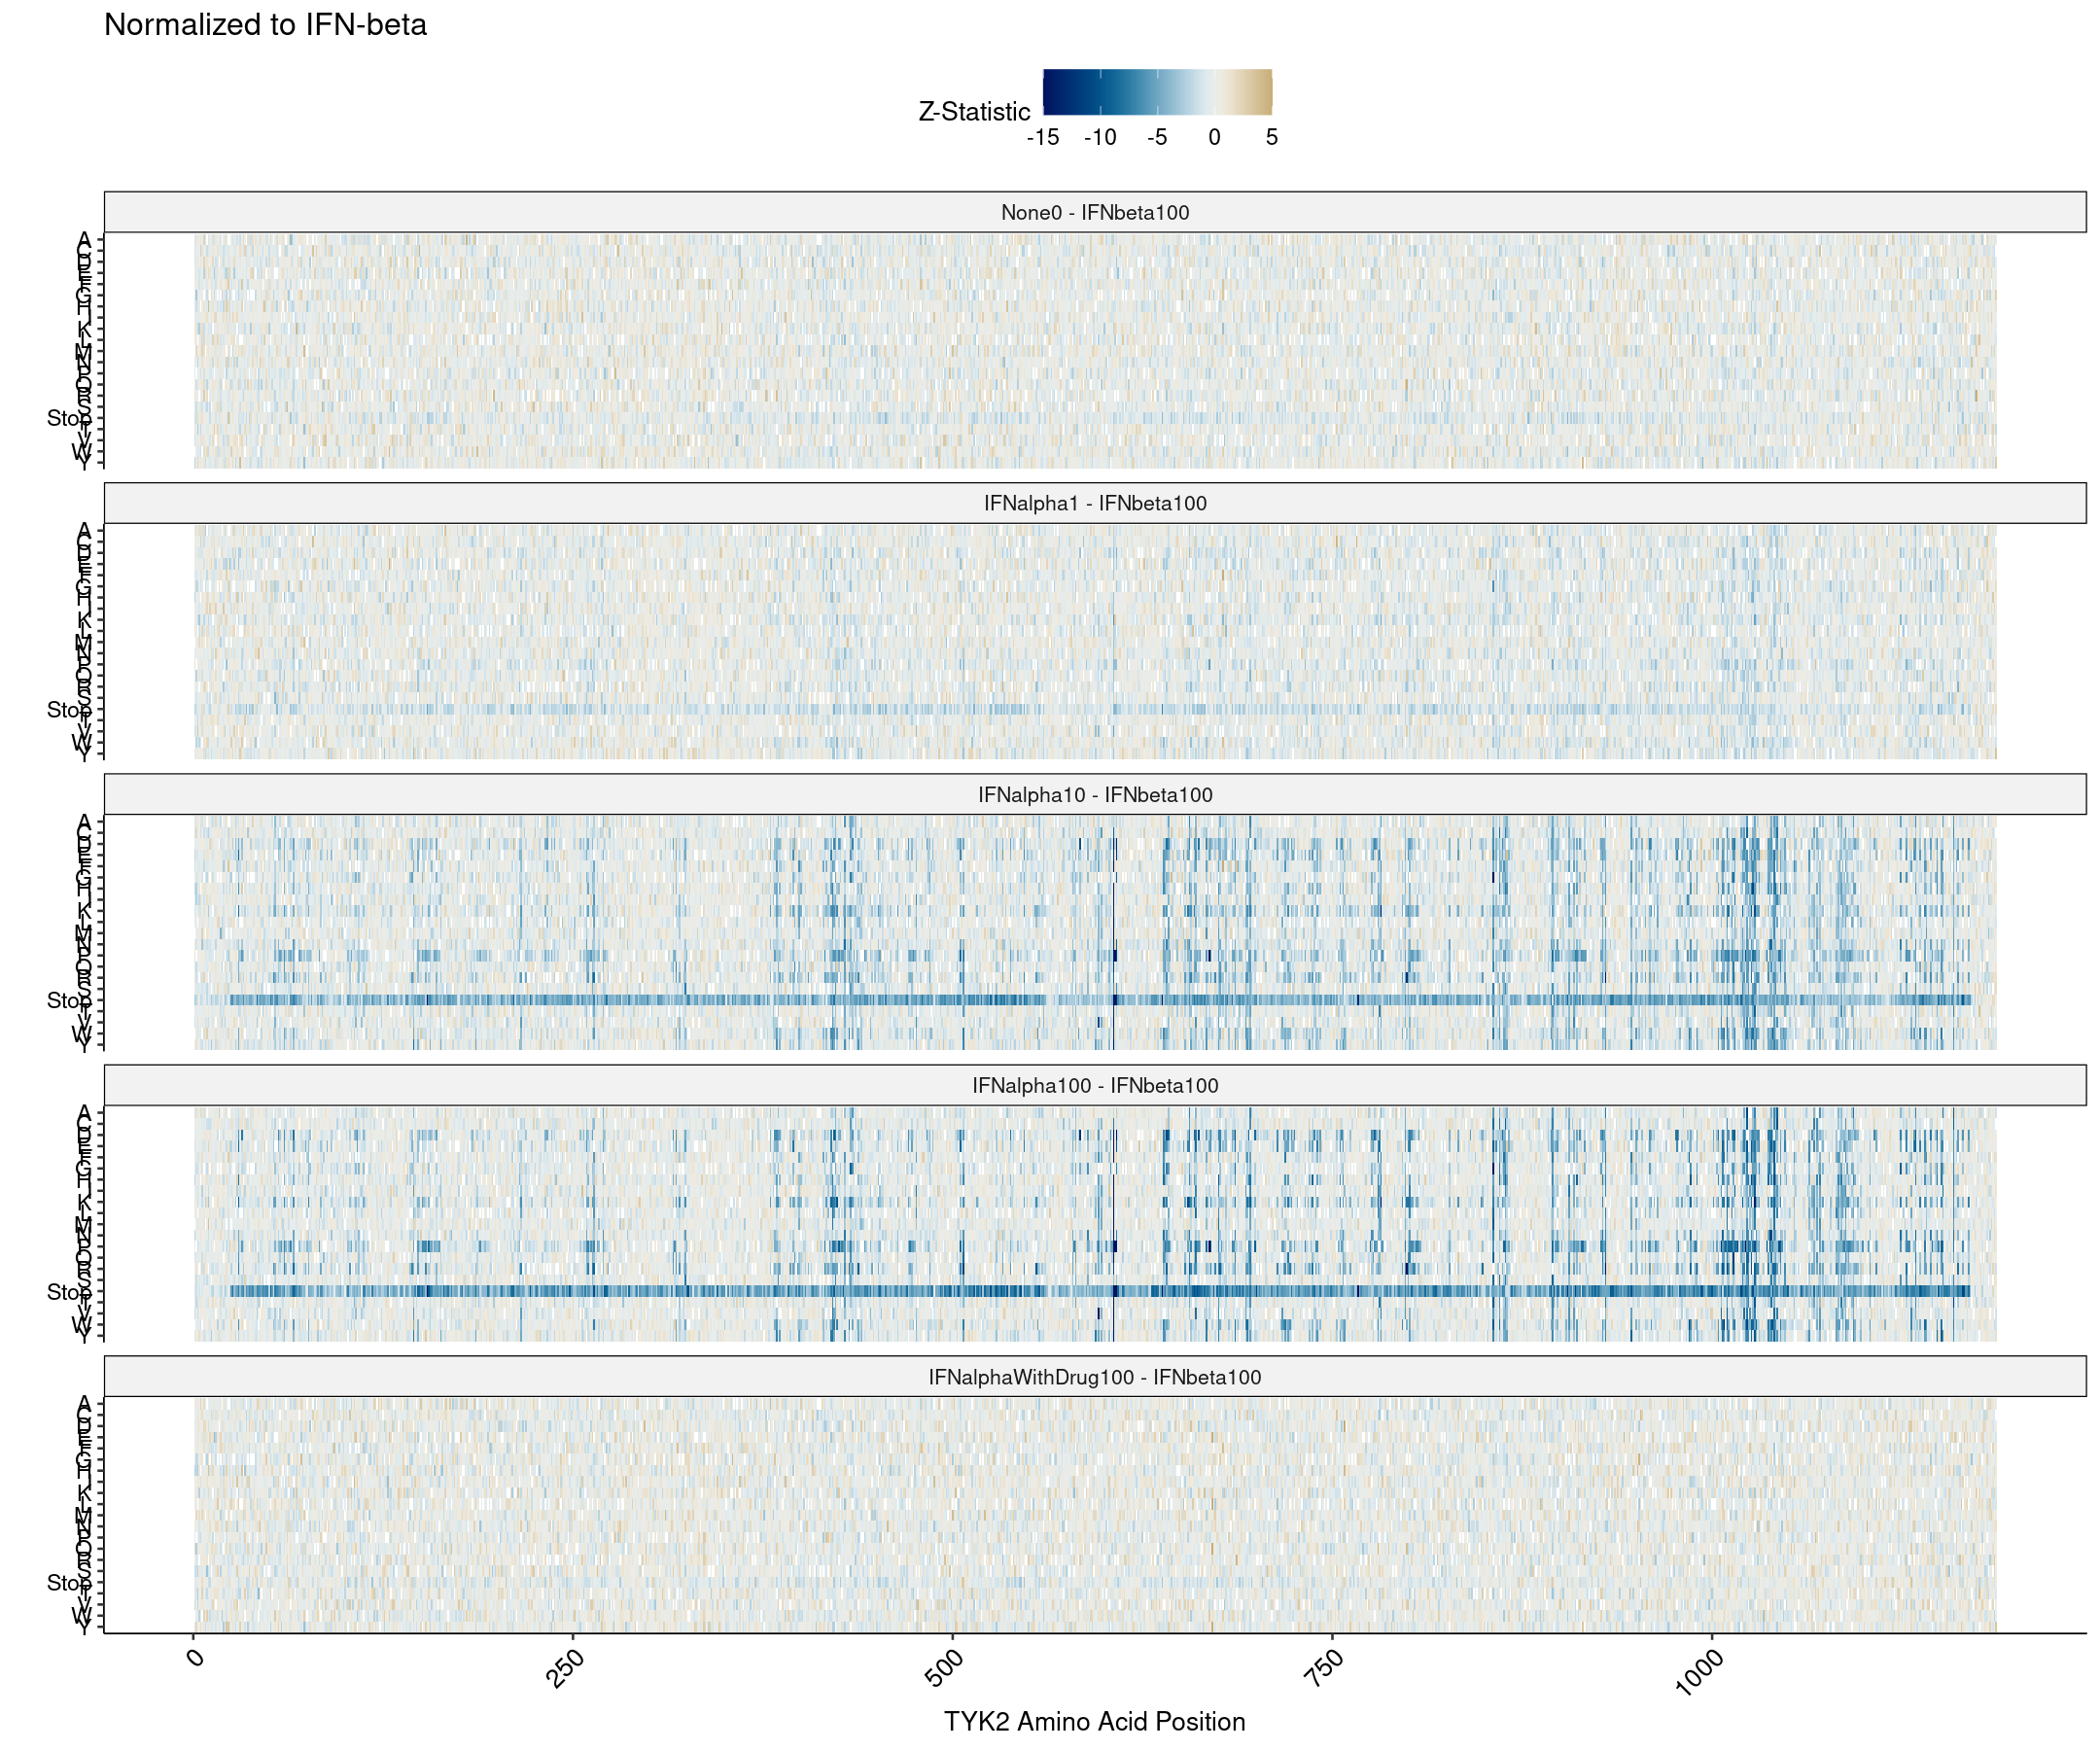

In [28]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats_all %>%
    filter(grepl("- IFNbeta100", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to IFN-beta")

sumstats_all %>%
    filter(grepl("- IFNbeta100", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to IFN-beta")

In [83]:
sumstats_volcano <- sumstats_all %>%
    filter(condition == "IFNalphaWithDrug100 - None0") %>%
    mutate(lab = str_c(pos, aa),
           lab = if_else(p.adj < 0.01, lab, ""))

volcano_plot <- ggplot() +
    geom_hline(yintercept = -log10(0.01), color = "red") +
    geom_point(data = sumstats_volcano,
               aes(x = estimate, y = -log10(p.adj),
                   color = if_else(-log10(p.adj) >= 2, "red", "black")),
               size = 2) +
    geom_label_repel(data = sumstats_volcano,
               aes(x = estimate, y = -log10(p.adj), label = lab),
               color = "red", size = 5,direction = "y",
                     ylim = c(2,Inf), nudge_x = 2.75 - sumstats_volcano$estimate) +
    theme_pubr(base_size = 16) +
    xlab("Log2 Fold Change") + ylab("-log10(FDR)") +
    scale_color_identity() +
    coord_cartesian(ylim = c(0,11)) +
    ggtitle("IFN-alpha + BMS-986202, Normalized to Untreated")

ggsave("../dataviz/TYK2/ifna//TYK2-IFNaDMS-Assay3-DrugResistVolcano.pdf",
       volcano_plot,
       width = 7, height = 6)

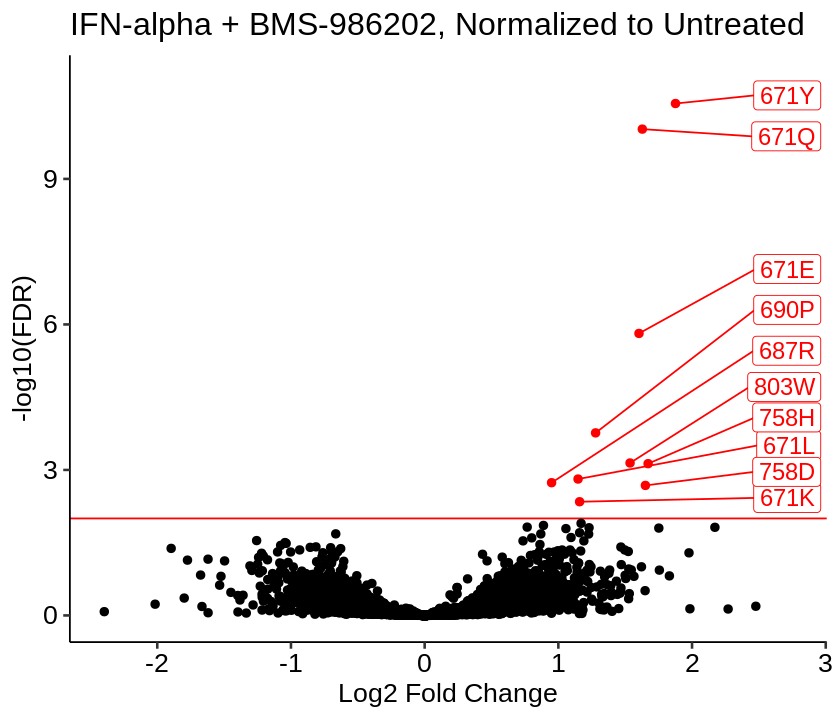

In [84]:
options(repr.plot.width = 7, repr.plot.height = 6)
volcano_plot

### Gain-of-Function <a name="part4"></a>

We clearly can identify Loss-of-Function variants very well, but can we detect any significant Gain-of-Function variants? Below, we normalize by subtracting `None` from `IFNalpha10` and sorting by the most significant _positive_ effects. We use `IFNalpha10` reasoning that a lighter stimulus might allow a larger dynamic range for positive, expression-increasing effects:

In [29]:
sumstats_all %>%
    filter(estimate > 0, condition == "IFNalpha10 - None0") %>%
    arrange(p.adj) %>%
    head(n=10) %>%
    rename("log2FoldChange" = "estimate") %>%
    kable(type = "markdown")



|  pos|clone |chunk |aa | log2FoldChange| std.error| dispersion|version |condition          | statistic|   p.value|     p.adj|
|----:|:-----|:-----|:--|--------------:|---------:|----------:|:-------|:------------------|---------:|---------:|---------:|
|  220|c8    |4     |S  |      1.4234249| 0.3456665|  0.8625597|v2.1.0  |IFNalpha10 - None0 |  4.117914| 0.0000382| 0.0011271|
|  544|c8    |8     |W  |      0.8458308| 0.2185625|  0.8692214|v2.1.0  |IFNalpha10 - None0 |  3.869972| 0.0001088| 0.0028774|
|   96|c8    |2     |W  |      1.2677983| 0.3493724|  0.8751519|v2.1.0  |IFNalpha10 - None0 |  3.628788| 0.0002848| 0.0067691|
|  262|c8    |4     |I  |      1.2390584| 0.3476599|  0.8625785|v2.1.0  |IFNalpha10 - None0 |  3.563996| 0.0003653| 0.0084223|
| 1142|c8    |17    |Q  |      1.0683177| 0.3001314|  0.8645981|v2.1.0  |IFNalpha10 - None0 |  3.559500| 0.0003716| 0.0085459|
|  678|c8    |10    |F  |      0.2880072| 0.0813095|  0.9019933|v2.1.0  |IFNalpha10 - None0 |  3.542110| 0.00

And the same, normalized to `IFNbeta100`:

In [30]:
sumstats_all %>%
    filter(estimate > 0, condition == "IFNalpha10 - IFNbeta100") %>%
    arrange(p.adj) %>%
    head(n=10) %>%
    rename("log2FoldChange" = "estimate") %>%
    kable(type = "markdown")



|  pos|clone |chunk |aa | log2FoldChange| std.error| dispersion|version |condition               | statistic|   p.value|     p.adj|
|----:|:-----|:-----|:--|--------------:|---------:|----------:|:-------|:-----------------------|---------:|---------:|---------:|
|  678|c8    |10    |F  |      0.5511683| 0.0802311|  0.9019933|v2.1.0  |IFNalpha10 - IFNbeta100 |  6.869756| 0.0000000| 0.0000000|
|  644|c8    |10    |G  |      1.0318508| 0.2562107|  0.9031483|v2.1.0  |IFNalpha10 - IFNbeta100 |  4.027352| 0.0000564| 0.0015976|
|  994|c8    |15    |Q  |      1.0903653| 0.2915067|  0.8772489|v2.1.0  |IFNalpha10 - IFNbeta100 |  3.740447| 0.0001837| 0.0045847|
|  865|c8    |13    |E  |      1.0837661| 0.2953856|  0.8828775|v2.1.0  |IFNalpha10 - IFNbeta100 |  3.668987| 0.0002435| 0.0059020|
| 1176|c8    |17    |T  |      1.1696930| 0.3333135|  0.8651627|v2.1.0  |IFNalpha10 - IFNbeta100 |  3.509288| 0.0004493| 0.0101138|
|  129|c8    |2     |E  |      0.9372831| 0.2747876|  0.8733427|v2.1.0  |I

Examining the heatmaps, there seem to be some very specific gain of function mutations that jump out of the combined treatment with IFN-alpha and Drug. Let's subtract None and IFN-beta from IFN-alpha with Drug and see:

In [31]:
sumstats_all %>%
    filter(estimate > 0, condition == "IFNalphaWithDrug100 - None0") %>%
    arrange(p.adj) %>%
    head(n=10) %>%
    rename("log2FoldChange" = "estimate") %>%
    kable(type = "markdown")

sumstats_all %>%
    filter(estimate > 0, condition == "IFNalphaWithDrug100 - IFNbeta100") %>%
    arrange(p.adj) %>%
    head(n=10) %>%
    rename("log2FoldChange" = "estimate") %>%
    kable(type = "markdown")



| pos|clone |chunk |aa | log2FoldChange| std.error| dispersion|version |condition                   | statistic|  p.value|     p.adj|
|---:|:-----|:-----|:--|--------------:|---------:|----------:|:-------|:---------------------------|---------:|--------:|---------:|
| 671|c8    |10    |Y  |      1.8762327| 0.2528983|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - None0 |  7.418921| 0.00e+00| 0.0000000|
| 671|c8    |10    |Q  |      1.6281940| 0.2250351|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - None0 |  7.235291| 0.00e+00| 0.0000000|
| 671|c8    |10    |E  |      1.6032344| 0.2870867|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - None0 |  5.584496| 0.00e+00| 0.0000015|
| 690|c8    |10    |P  |      1.2785861| 0.2790964|  0.9042129|v2.1.0  |IFNalphaWithDrug100 - None0 |  4.581163| 4.60e-06| 0.0001722|
| 803|c8    |12rc  |W  |      1.5363432| 0.3629702|  0.8927898|v2.1.0  |IFNalphaWithDrug100 - None0 |  4.232698| 2.31e-05| 0.0007182|
| 758|c8    |11    |H  |      1.6713900| 0.3956623|  0.91105



|  pos|clone |chunk |aa | log2FoldChange| std.error| dispersion|version |condition                        | statistic|  p.value|     p.adj|
|----:|:-----|:-----|:--|--------------:|---------:|----------:|:-------|:--------------------------------|---------:|--------:|---------:|
|  671|c8    |10    |Q  |       1.802742| 0.2221113|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - IFNbeta100 |  8.116392| 0.00e+00| 0.0000000|
|  758|c8    |11    |D  |       2.754826| 0.4134491|  0.9110504|v2.1.0  |IFNalphaWithDrug100 - IFNbeta100 |  6.663036| 0.00e+00| 0.0000000|
|  671|c8    |10    |Y  |       1.558015| 0.2478449|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - IFNbeta100 |  6.286251| 0.00e+00| 0.0000000|
|  671|c8    |10    |L  |       1.417474| 0.2769616|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - IFNbeta100 |  5.117946| 3.00e-07| 0.0000153|
|  671|c8    |10    |E  |       1.383624| 0.2823585|  0.9051413|v2.1.0  |IFNalphaWithDrug100 - IFNbeta100 |  4.900239| 1.00e-06| 0.0000421|
|  952|c8    |14  

Since position 671 jumps out, let's extract the summary statistics for that position in all conditions. Significant effects (FDR < 1%) are highlighted in magenta:

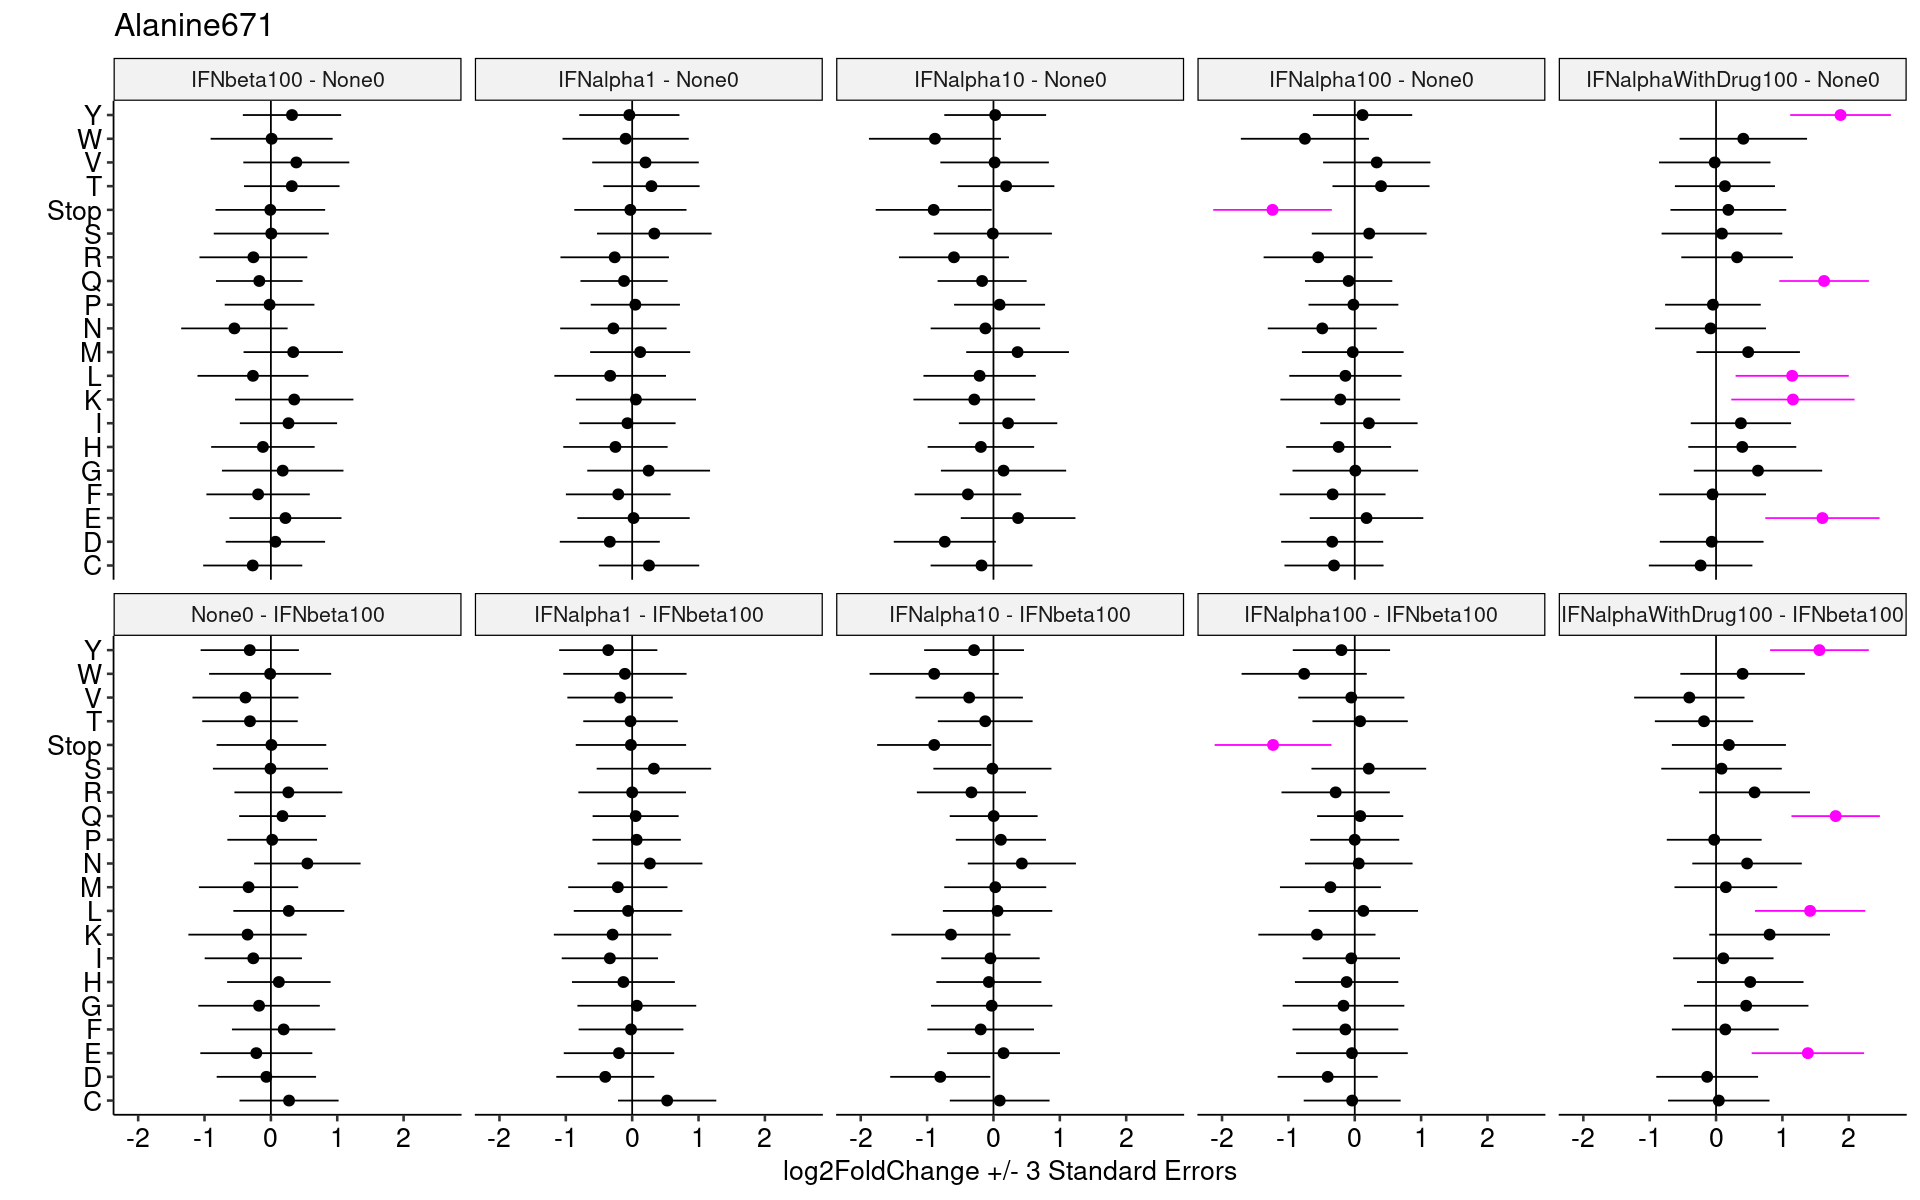

In [32]:
options(repr.plot.width = 16, repr.plot.height = 10)
sumstats_all %>%
    filter(pos == 671) %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_pointrange(aes(x = aa, y = estimate,
                            ymin = estimate - 3*std.error,
                            ymax = estimate + 3*std.error,
                            color = if_else(p.adj < 0.01, "magenta", "black"))) +
        facet_wrap(~condition, nrow = 2) +
        theme_pubr(base_size = 16) +
        coord_flip() +
        geom_hline(yintercept = 0) +
        xlab("") + ylab("log2FoldChange +/- 3 Standard Errors") +
        ggtitle("Alanine671") +
        scale_color_identity()



There are some _very_ strong (compared to what we usually see) gain-of-function effects in chunk 10 associated with drug treatment (there is visually no trace of these in any condition other than IFN-alpha 100 + Drug). We obviously detect far, far more LoF variation but we do appear to have sufficient power to begin to curate a set of putative GoF variants in addition to LoF.

### Spike-Ins <a name="part5"></a>

Similar to Alanine671, we can make the same plots for all our spike-in variants:

In [33]:
spikeins <- read_tsv("../design/tyk2-vars.tsv") %>%
    mutate(mut_id = paste0(wt_residue, position, mut_residue)) %>%
    select(mut_id) %>%
    unlist()

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): wt_residue, mut_residue, ref, alt
dbl (2): position, position_nuc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, see `problems()` for details”


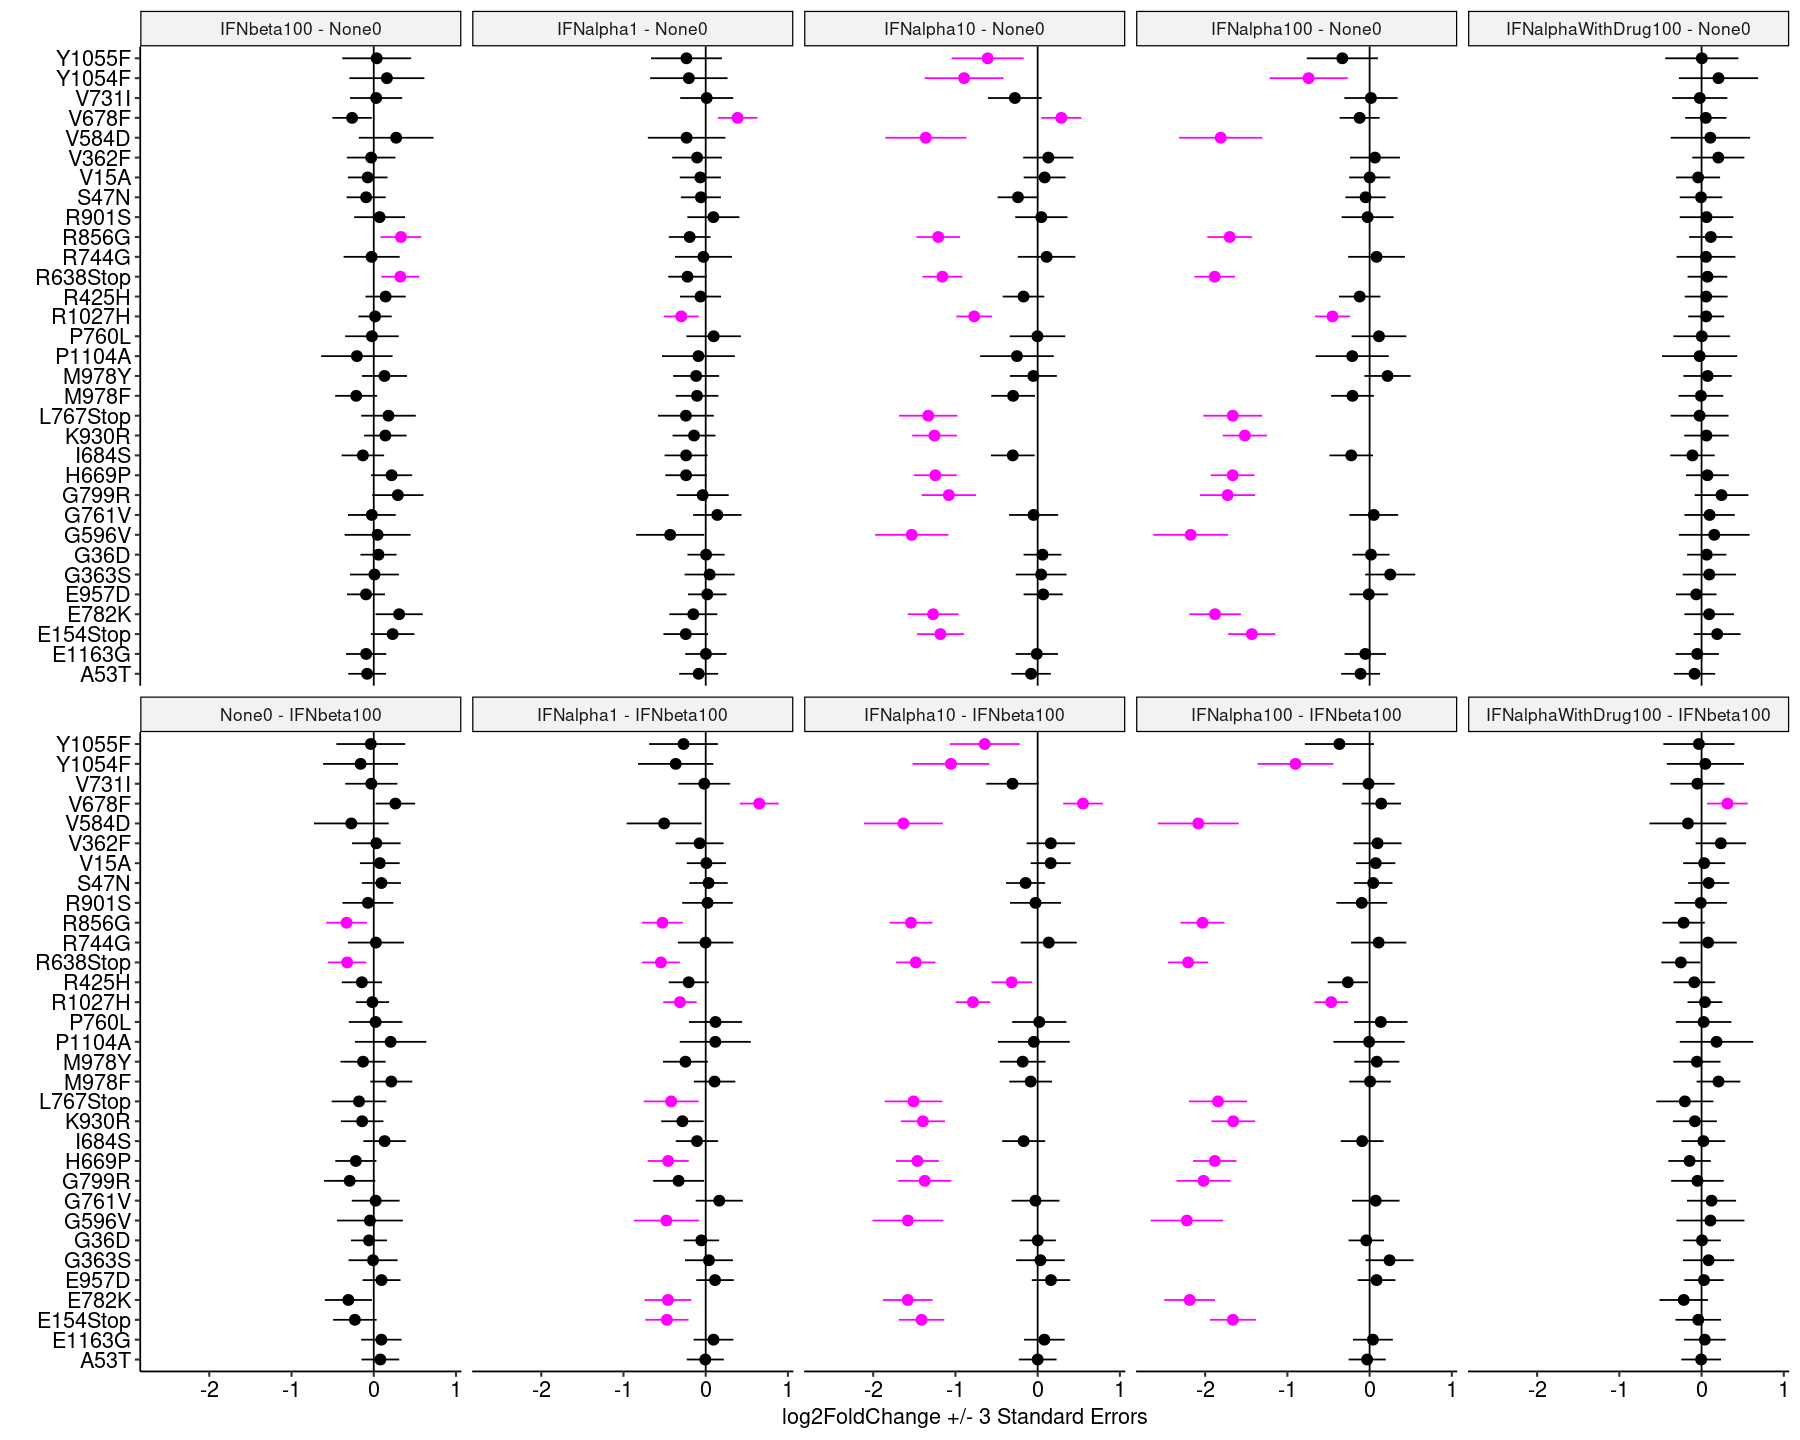

In [34]:
options(repr.plot.width = 15, repr.plot.height = 12)
sumstats_all %>%
    left_join(wt_aa, by = "pos") %>%
    filter(paste0(wt_aa, pos, aa) %in% spikeins) %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_pointrange(aes(x = paste0(wt_aa, pos, aa), y = estimate,
                            ymin = estimate - 3*std.error,
                            ymax = estimate + 3*std.error,
                            color = if_else(p.adj < 0.01, "magenta", "black"))) +
        theme_pubr(base_size = 13) +
        coord_flip() +
        geom_hline(yintercept = 0) +
        xlab("") + ylab("log2FoldChange +/- 3 Standard Errors") +
        facet_wrap(~condition, nrow = 2) +
        scale_color_identity()

### Positionwise Aggregation <a name="part6"></a>

For painting on a structure, we need a single number per position instead of 20 numbers (and 20 standard errors on those numbers). We could subset particular amino acids to collapse, but the simplest starting point is to just collapse everything except for stop codons - that is, take the average across all mutation effects in all non-stop amino acids. This dampens the effect of most mutations, since in most cases this will average inactive variants at the same position with active variants, but returns tracks where each TYK2 position is assigned a single number:

In [35]:
aggregate_cols <- function(df, method = c("average", "maximum", "average_significant")) {
    
    if(method %in% c("average", "average_significant")){
        
        if(method == "average_significant"){
            thresh <- 0.01
        }else{
            thresh <- 2
        }
        
        agg_data <-  df %>%
            ungroup() %>%
            filter(aa != "*", p.adj < thresh) %>%
            group_by(pos, clone, chunk, version, condition) %>%
            summarize(estimate = mean(estimate),
                      std.error = sqrt(sum(std.error^2)/length(unique(aa))),
                      statistic = estimate / std.error) %>%
            mutate(condition = paste0(condition, " ", "Aggregated Across Residues"))

        null_rows <- expand_grid(pos = 1:1187,
                    condition = unique(paste0(df$condition, " ", "Aggregated Across Residues")), 
                    statistic = 0) %>%
            filter(!paste0(pos, condition) %in% paste0(agg_data$pos, agg_data$condition))

        agg_data <- agg_data %>%
            ungroup() %>%
            select(pos, condition, statistic) %>% 
            bind_rows(null_rows)

        return(agg_data)
        
    } else if(method == "maximum") {
        
        agg_data <-  df %>%
            ungroup() %>%
            filter(aa != "*") %>%
            group_by(pos, clone, chunk, version, condition) %>%
            filter(statistic == sign(statistic)*max(abs(statistic))) %>%
            ungroup() %>%
            select(pos, condition, statistic)
        
        return(agg_data)
    }
}

In [36]:
agg1_data_avg <-  aggregate_cols(sumstats_all %>% filter(grepl("- None0", condition)), method = "average") %>%
    mutate(method = "average")
agg2_data_avg <-   aggregate_cols(sumstats_all %>% filter(grepl("- IFNbeta100", condition)), method = "average") %>%
    mutate(method = "average")

agg1 <- ggplot(agg1_data_avg) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Average of Residues At Position")
agg2<- ggplot(agg2_data_avg) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Average of Residues At Position")

`summarise()` has grouped output by 'pos', 'clone', 'chunk', 'version'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'pos', 'clone', 'chunk', 'version'. You can override using the `.groups` argument.


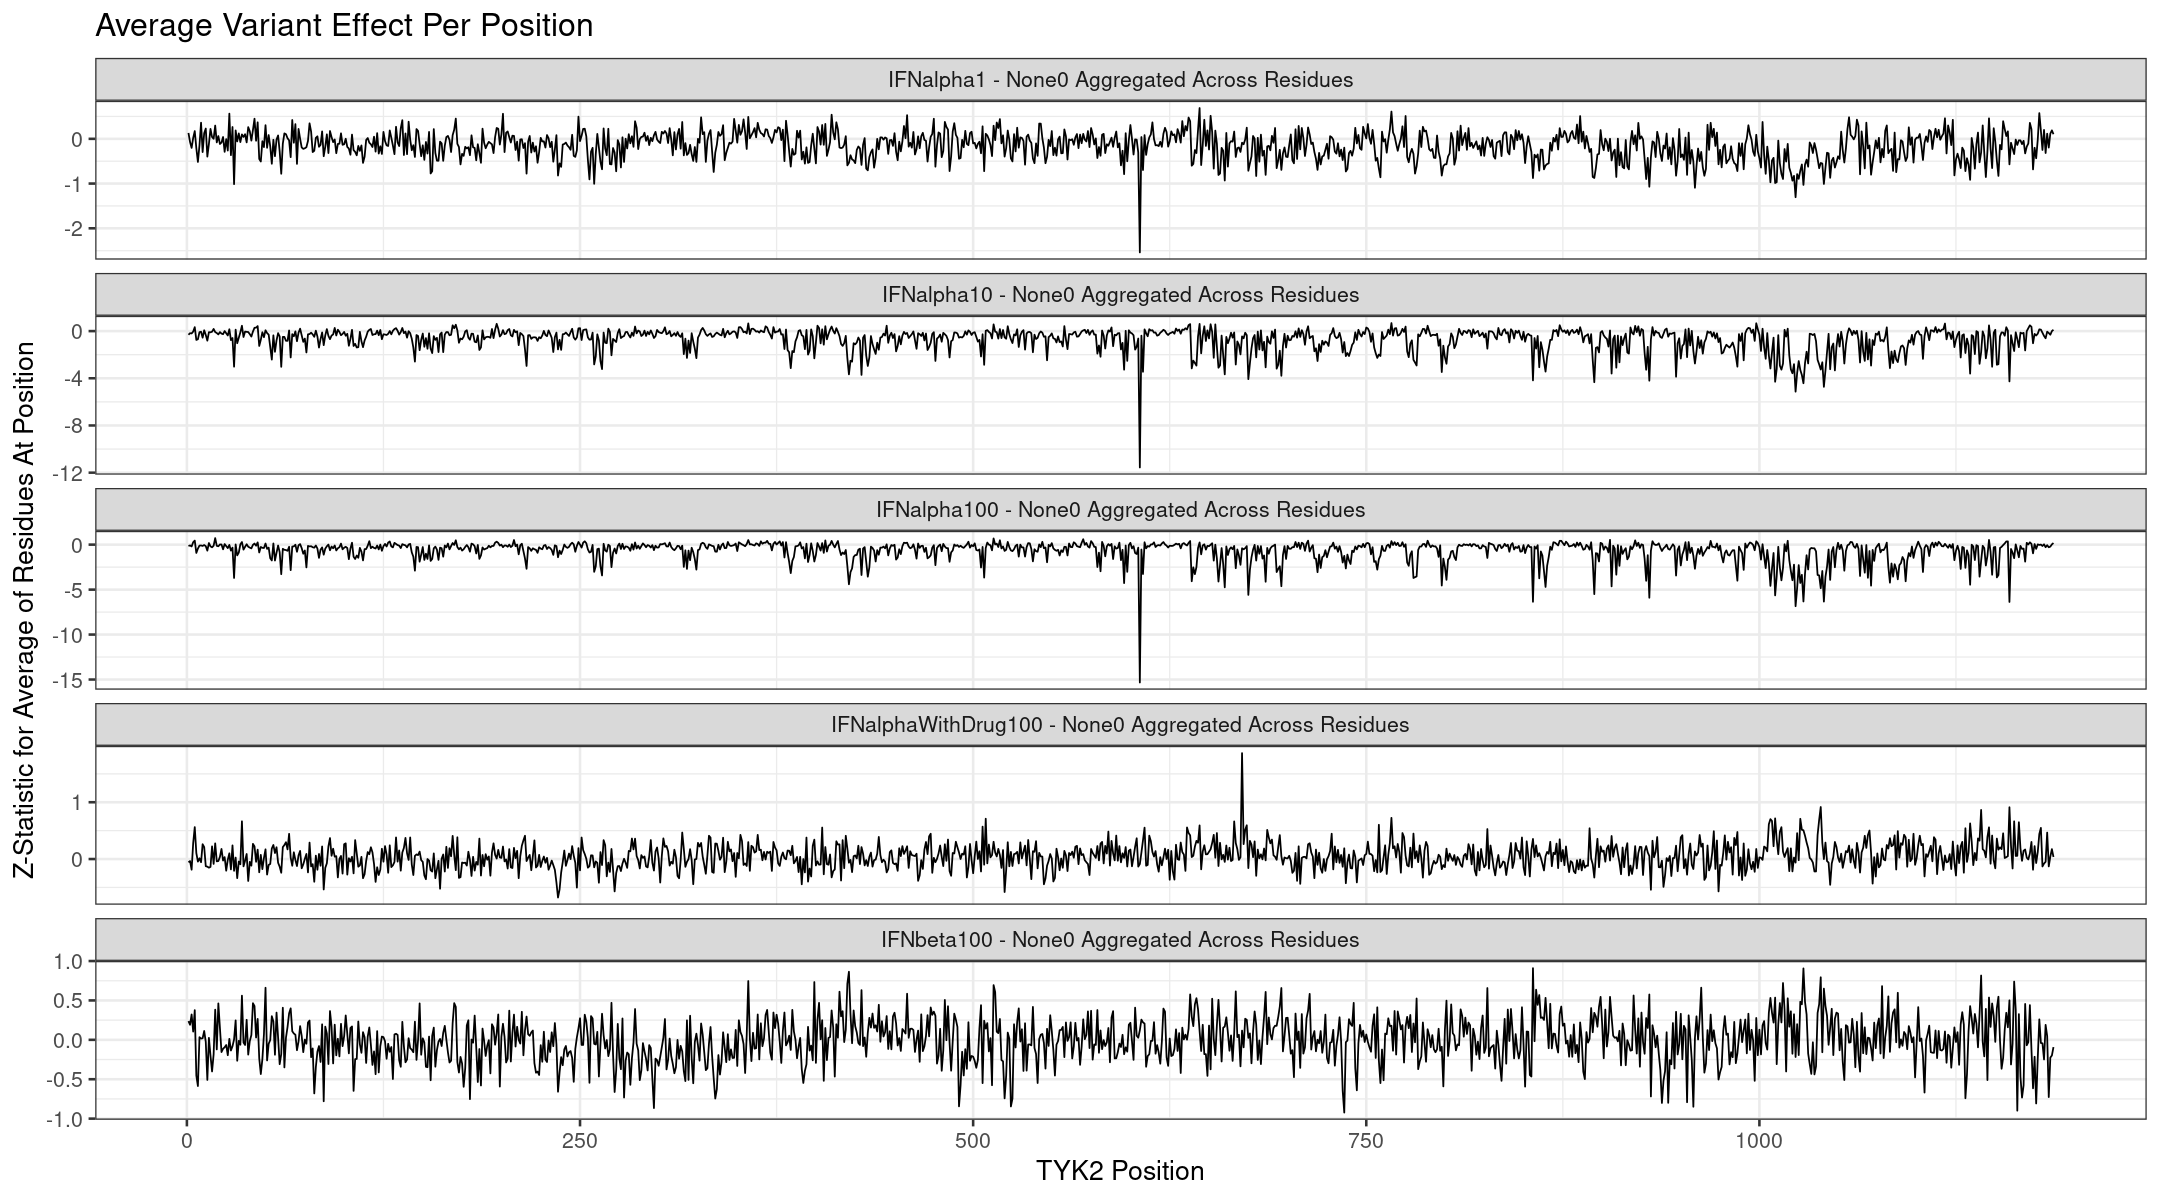

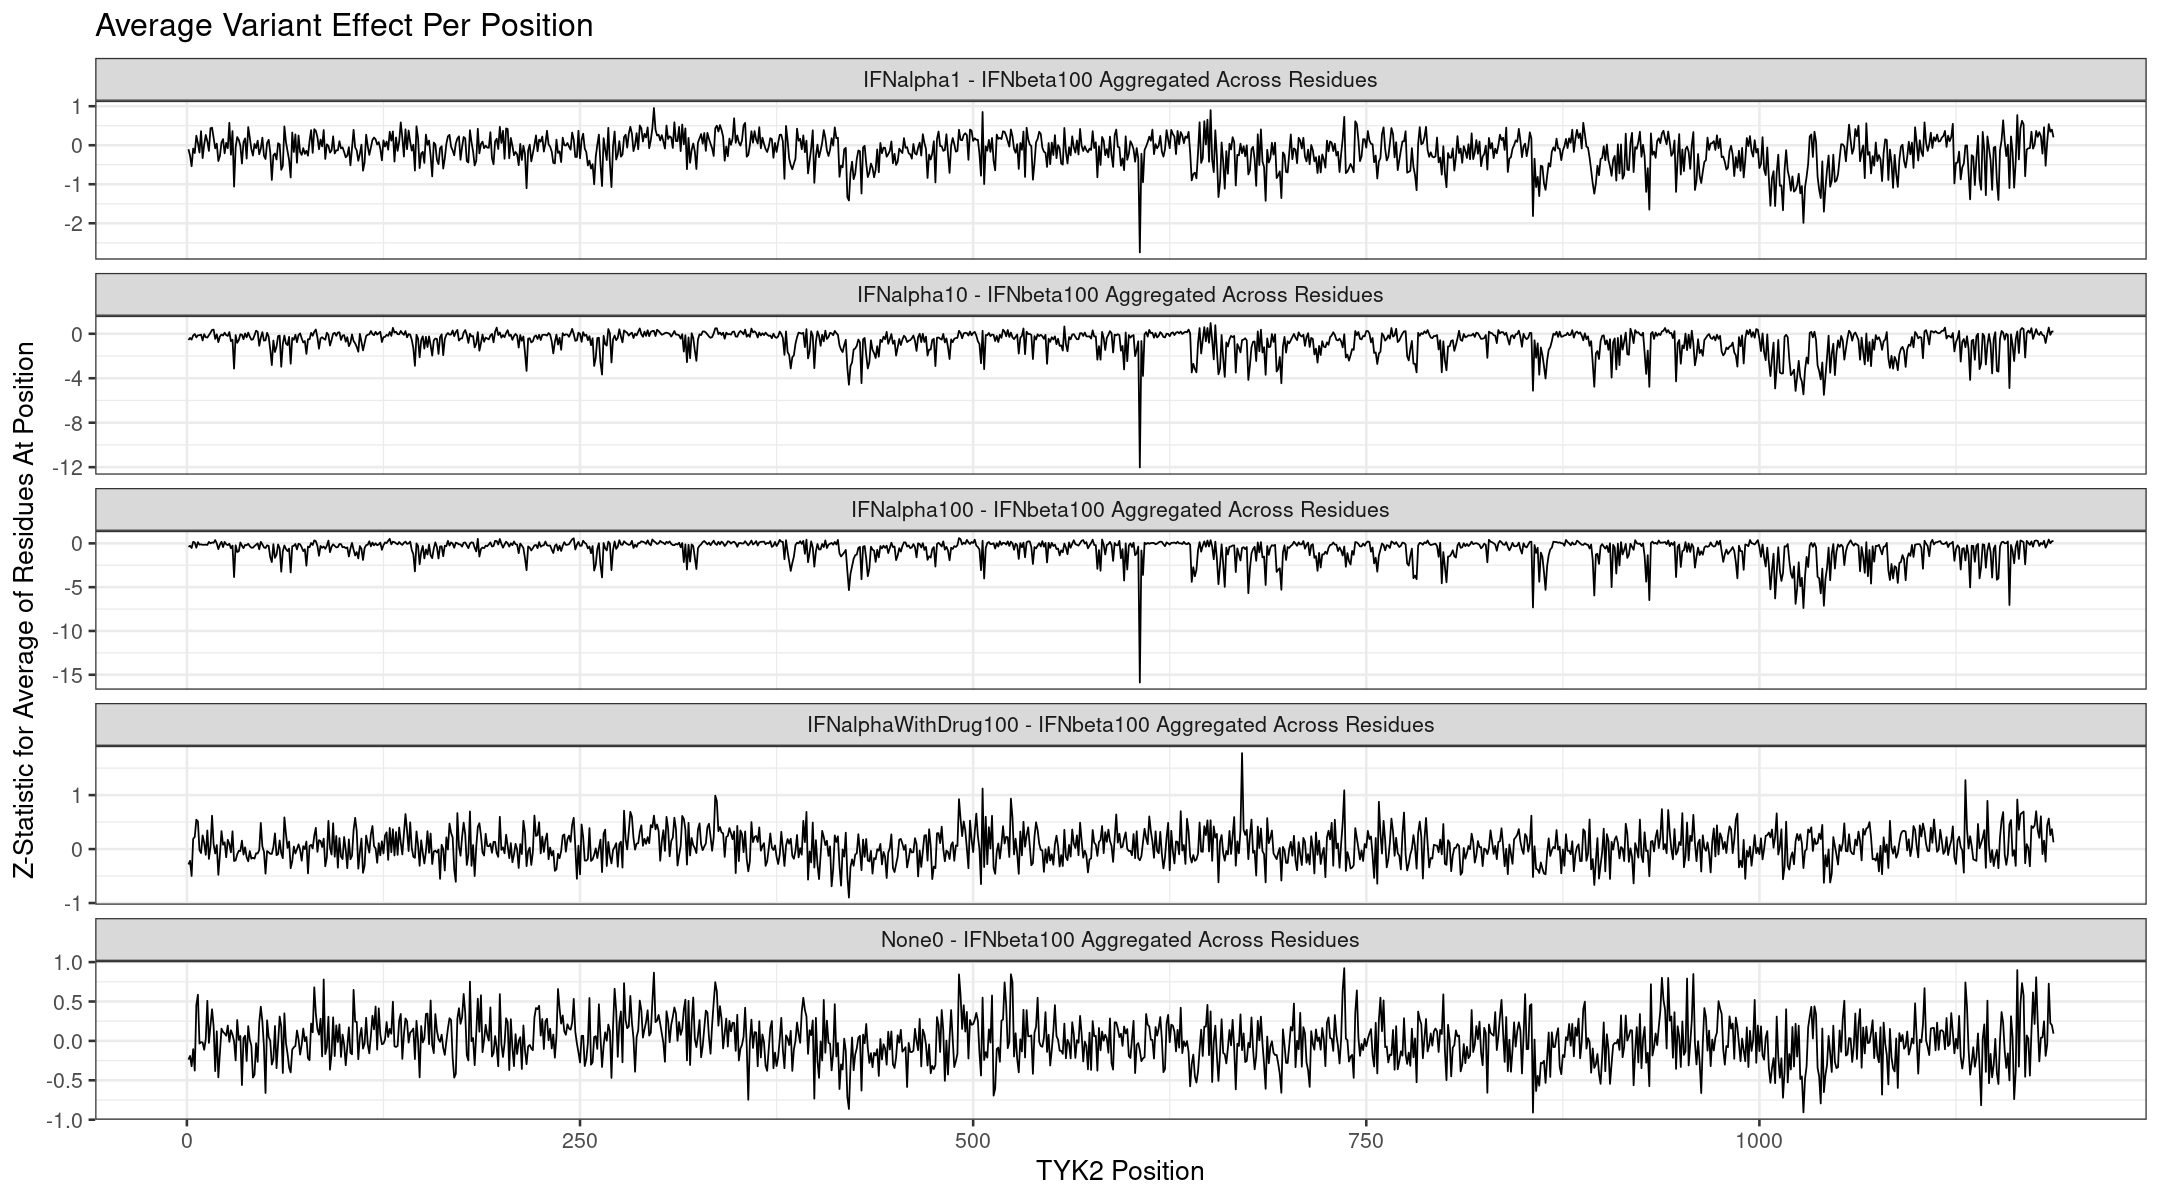

In [37]:
options(repr.plot.width = 18, repr.plot.height = 10)
agg1 + ggtitle("Average Variant Effect Per Position")
agg2 + ggtitle("Average Variant Effect Per Position")

To prevent the dampening, we could instead take the average variant effect at each position for only significant (FDR < 1%) variants, and assign zero to all other non-significant variants. Now, many positions shrink to zero and significant positions are very spiky:

In [38]:
agg1_data_avgsig <-  aggregate_cols(sumstats_all %>% filter(grepl("- None0", condition)), method = "average_significant") %>%
    mutate(method = "average_significant")
agg2_data_avgsig <-   aggregate_cols(sumstats_all %>% filter(grepl("- IFNbeta100", condition)), method = "average_significant") %>%
    mutate(method = "average_significant")   

agg1 <- ggplot(agg1_data_avgsig) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Average of Residues At Position")
agg2<- ggplot(agg2_data_avgsig) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Average of Residues At Position")

`summarise()` has grouped output by 'pos', 'clone', 'chunk', 'version'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'pos', 'clone', 'chunk', 'version'. You can override using the `.groups` argument.


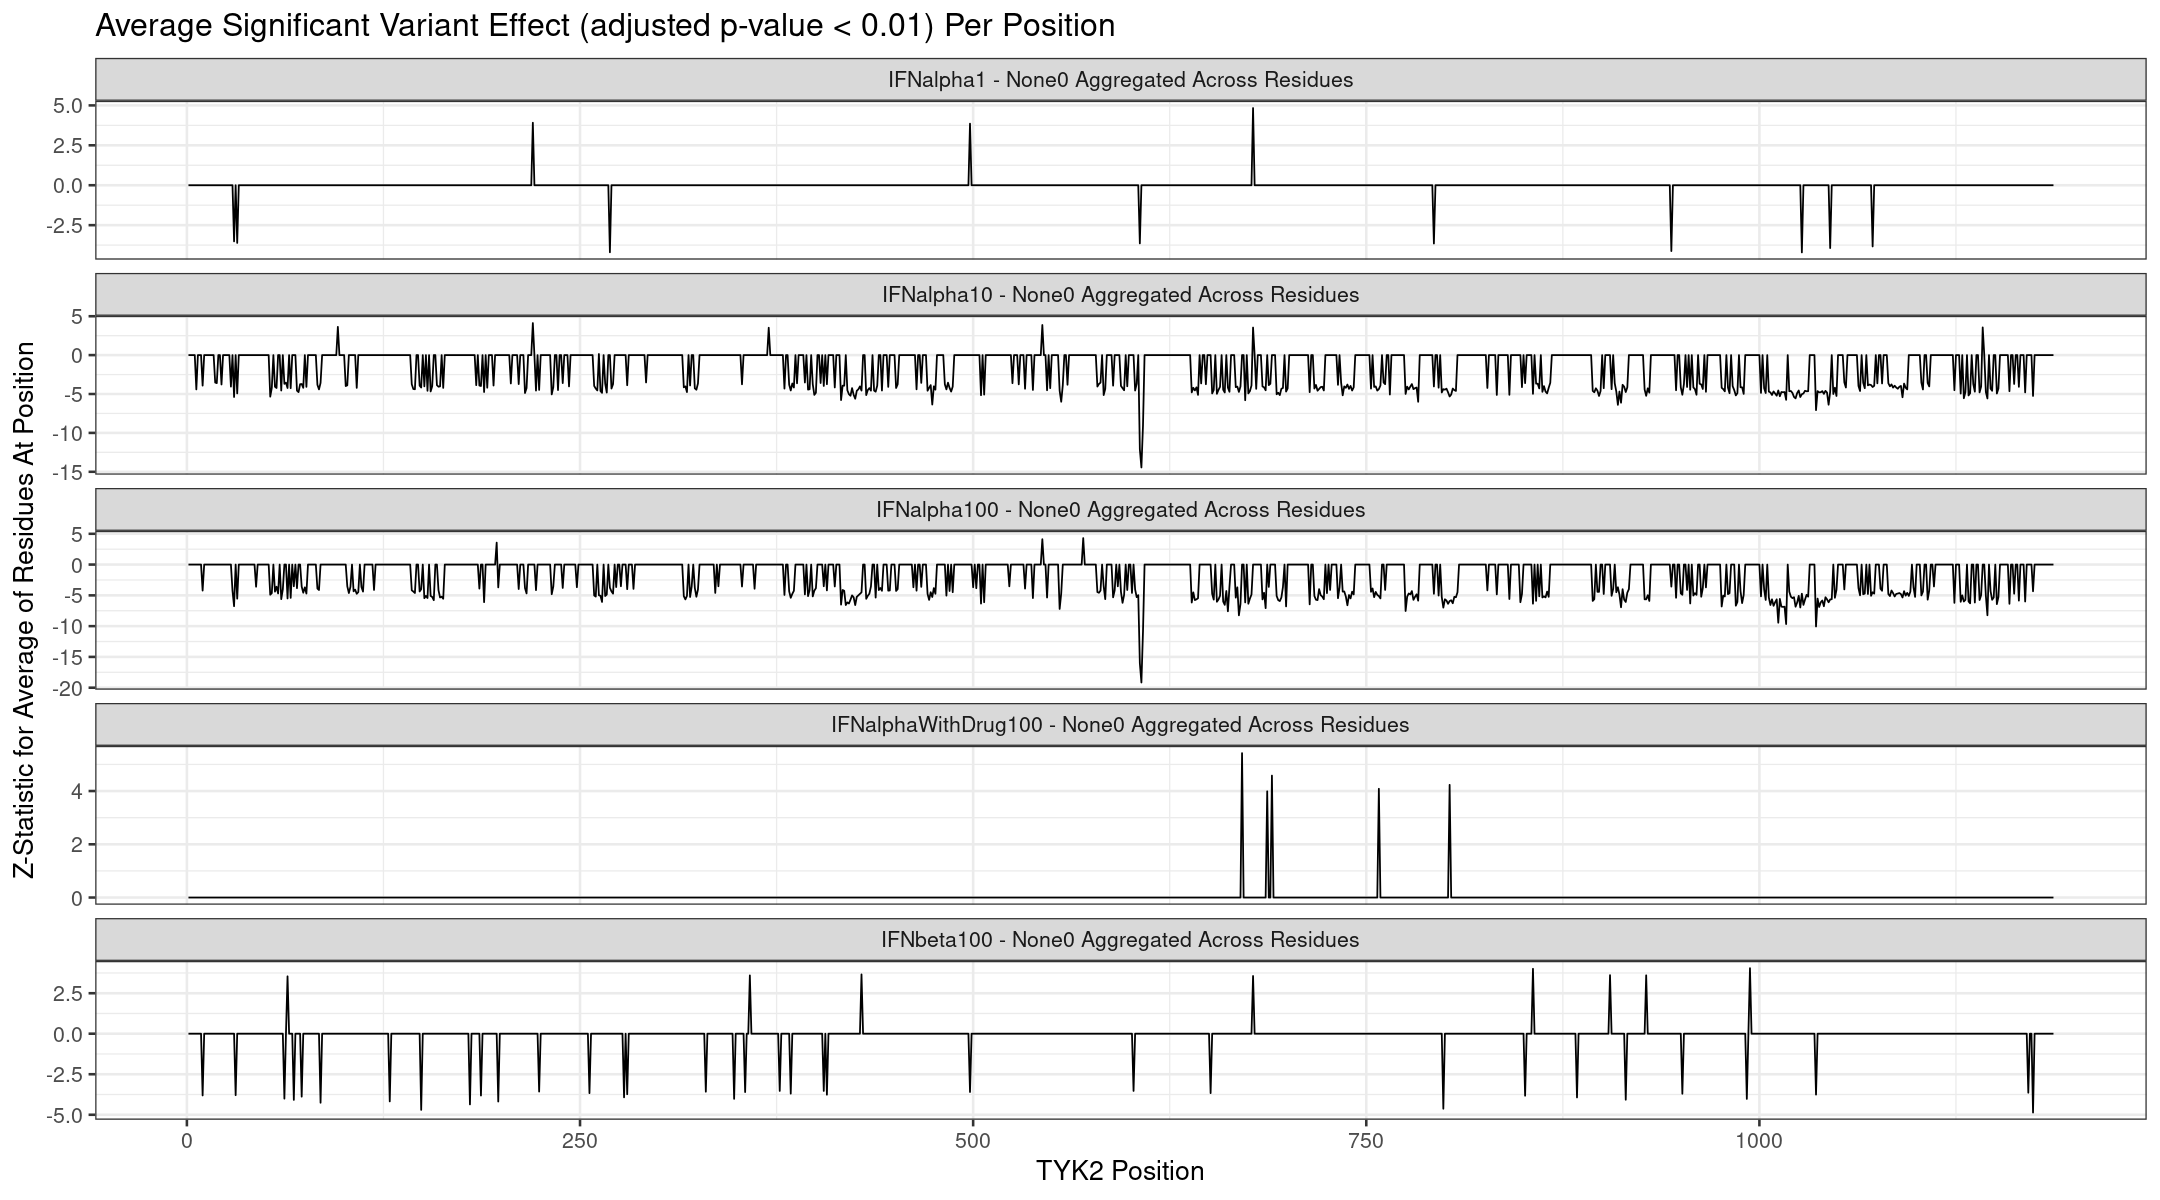

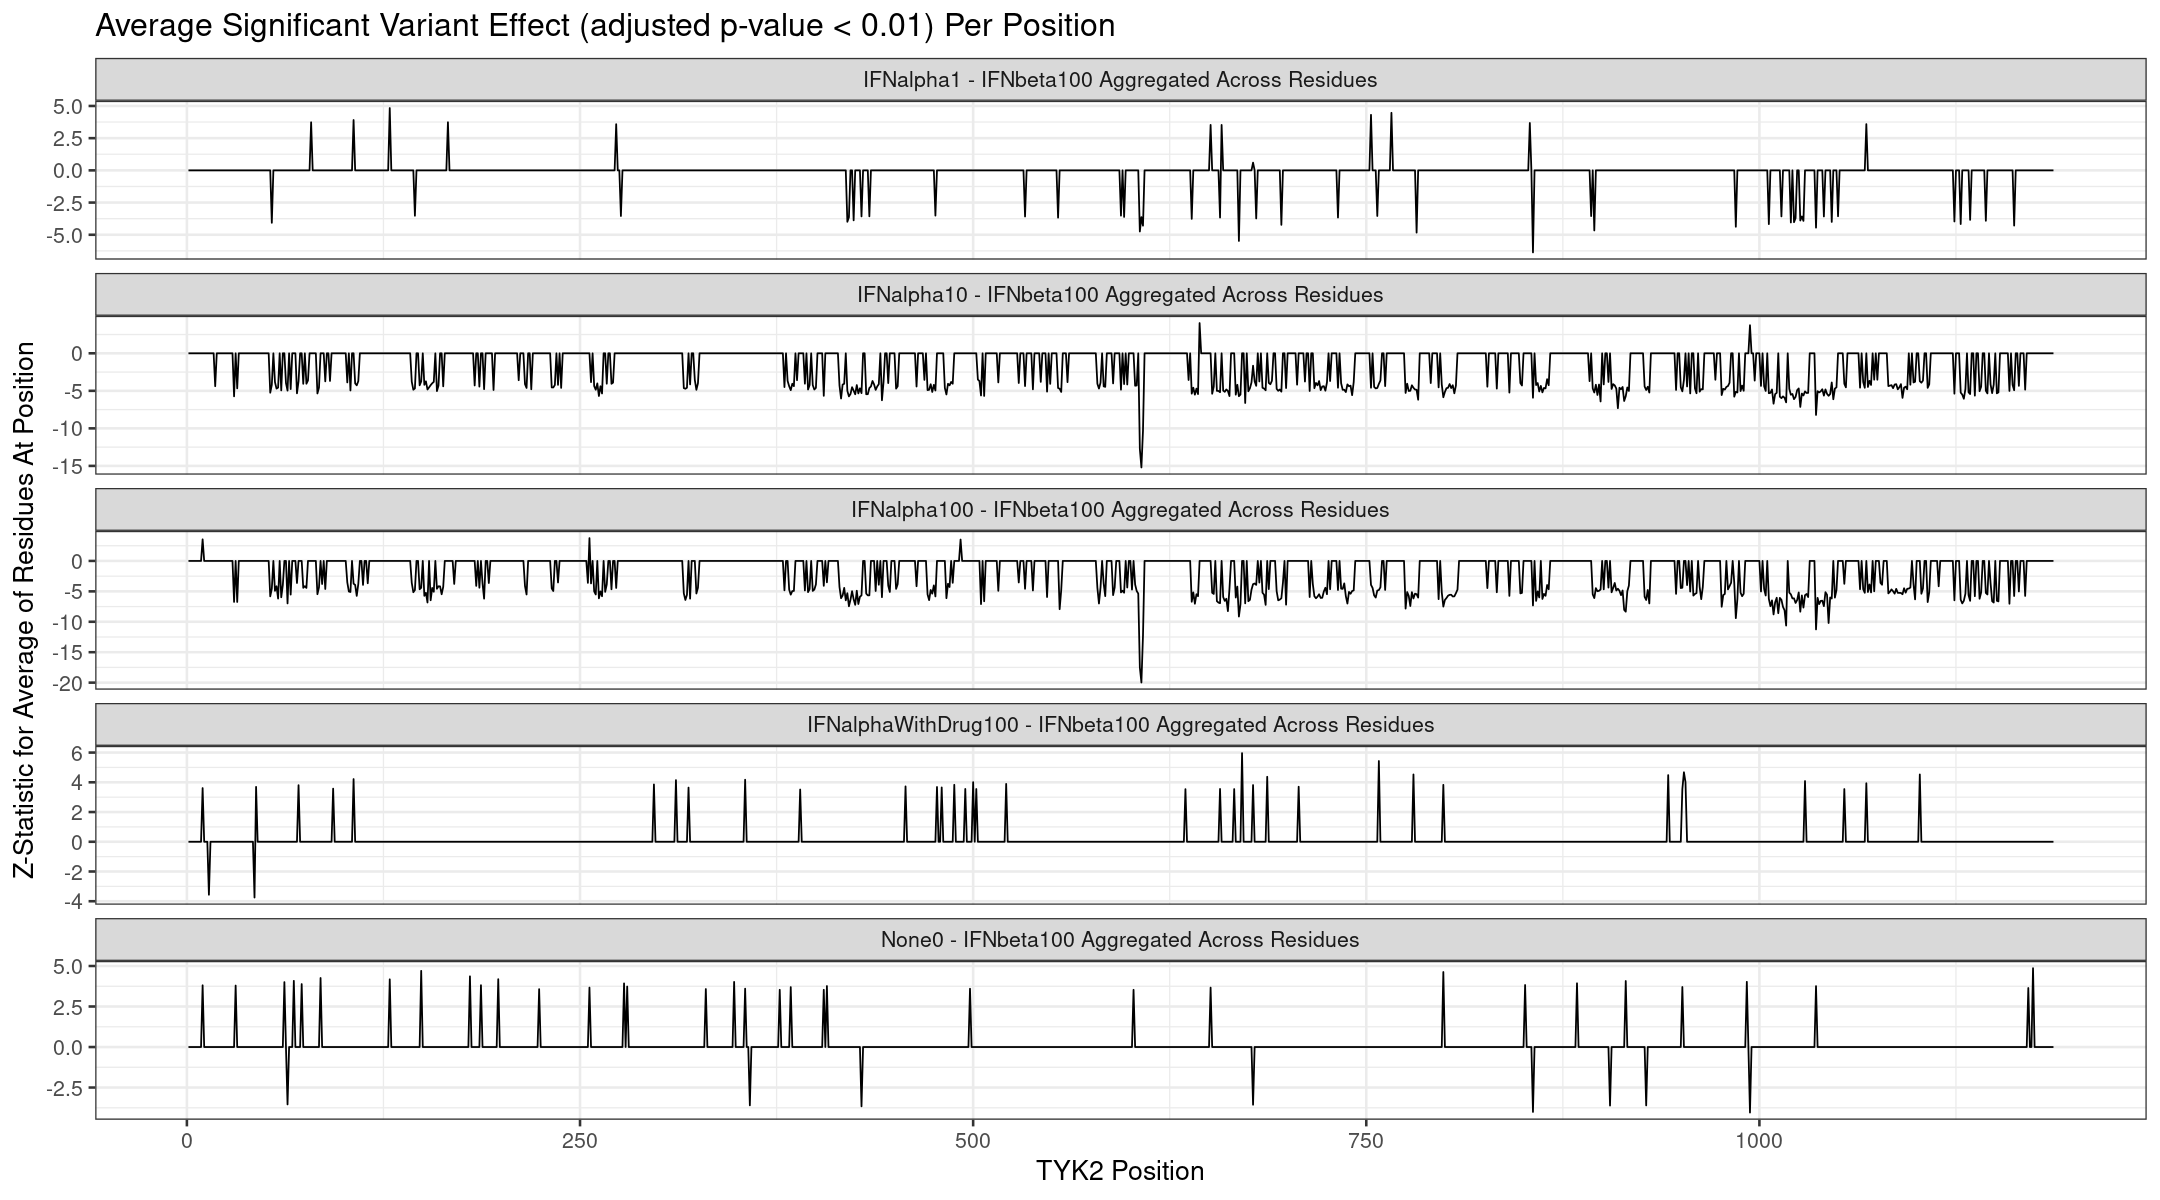

In [39]:
options(repr.plot.width = 18, repr.plot.height = 10)
agg1 + ggtitle("Average Significant Variant Effect (adjusted p-value < 0.01) Per Position")
agg2 + ggtitle("Average Significant Variant Effect (adjusted p-value < 0.01) Per Position")

Another approach to aggregation is to take the maximum significant effect at each position, where the "maximum effect" means the largest absolute z-statistic per position:

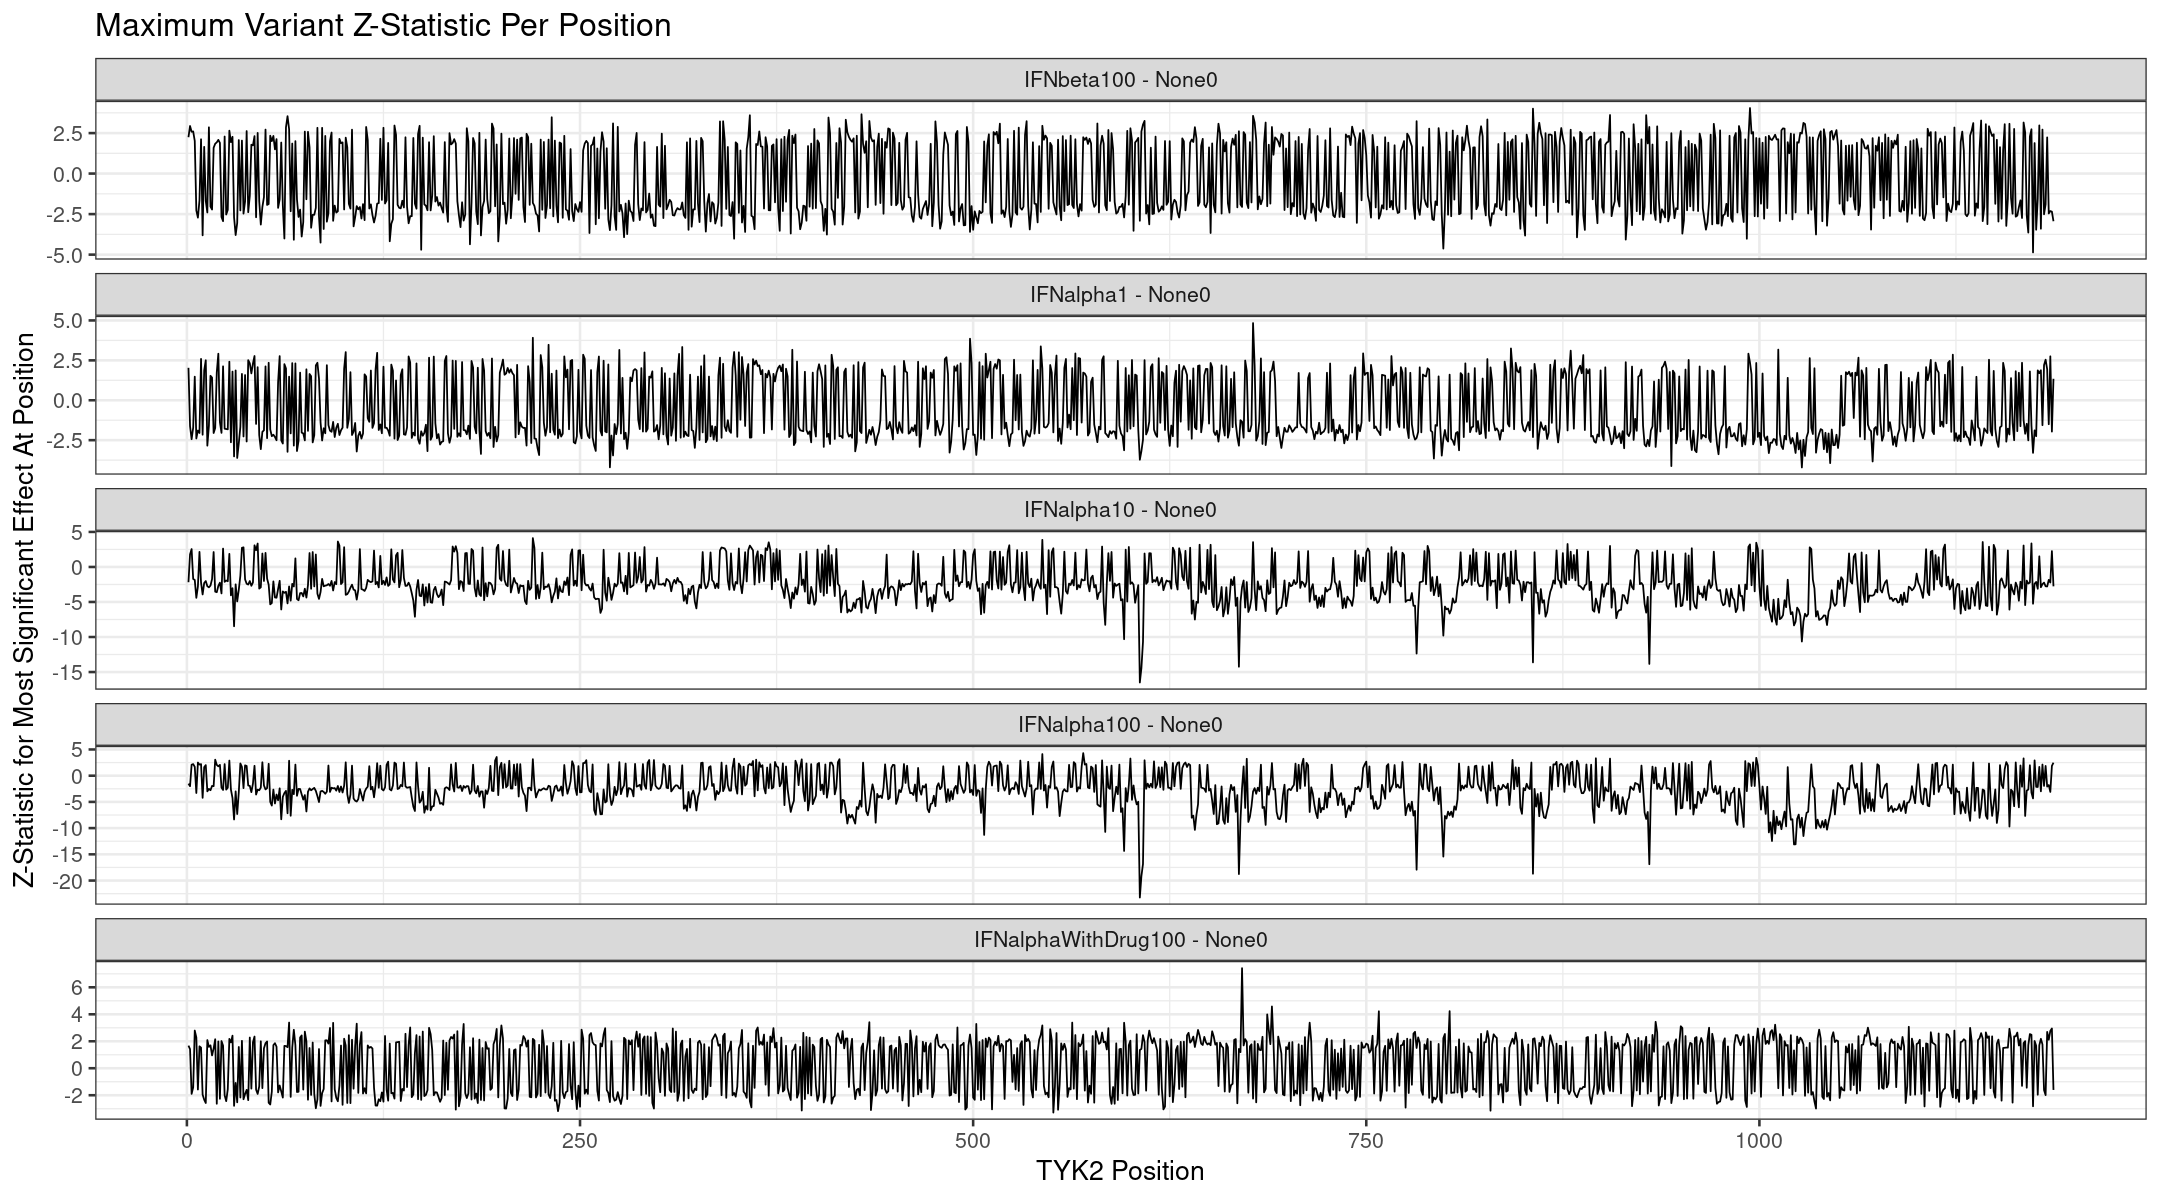

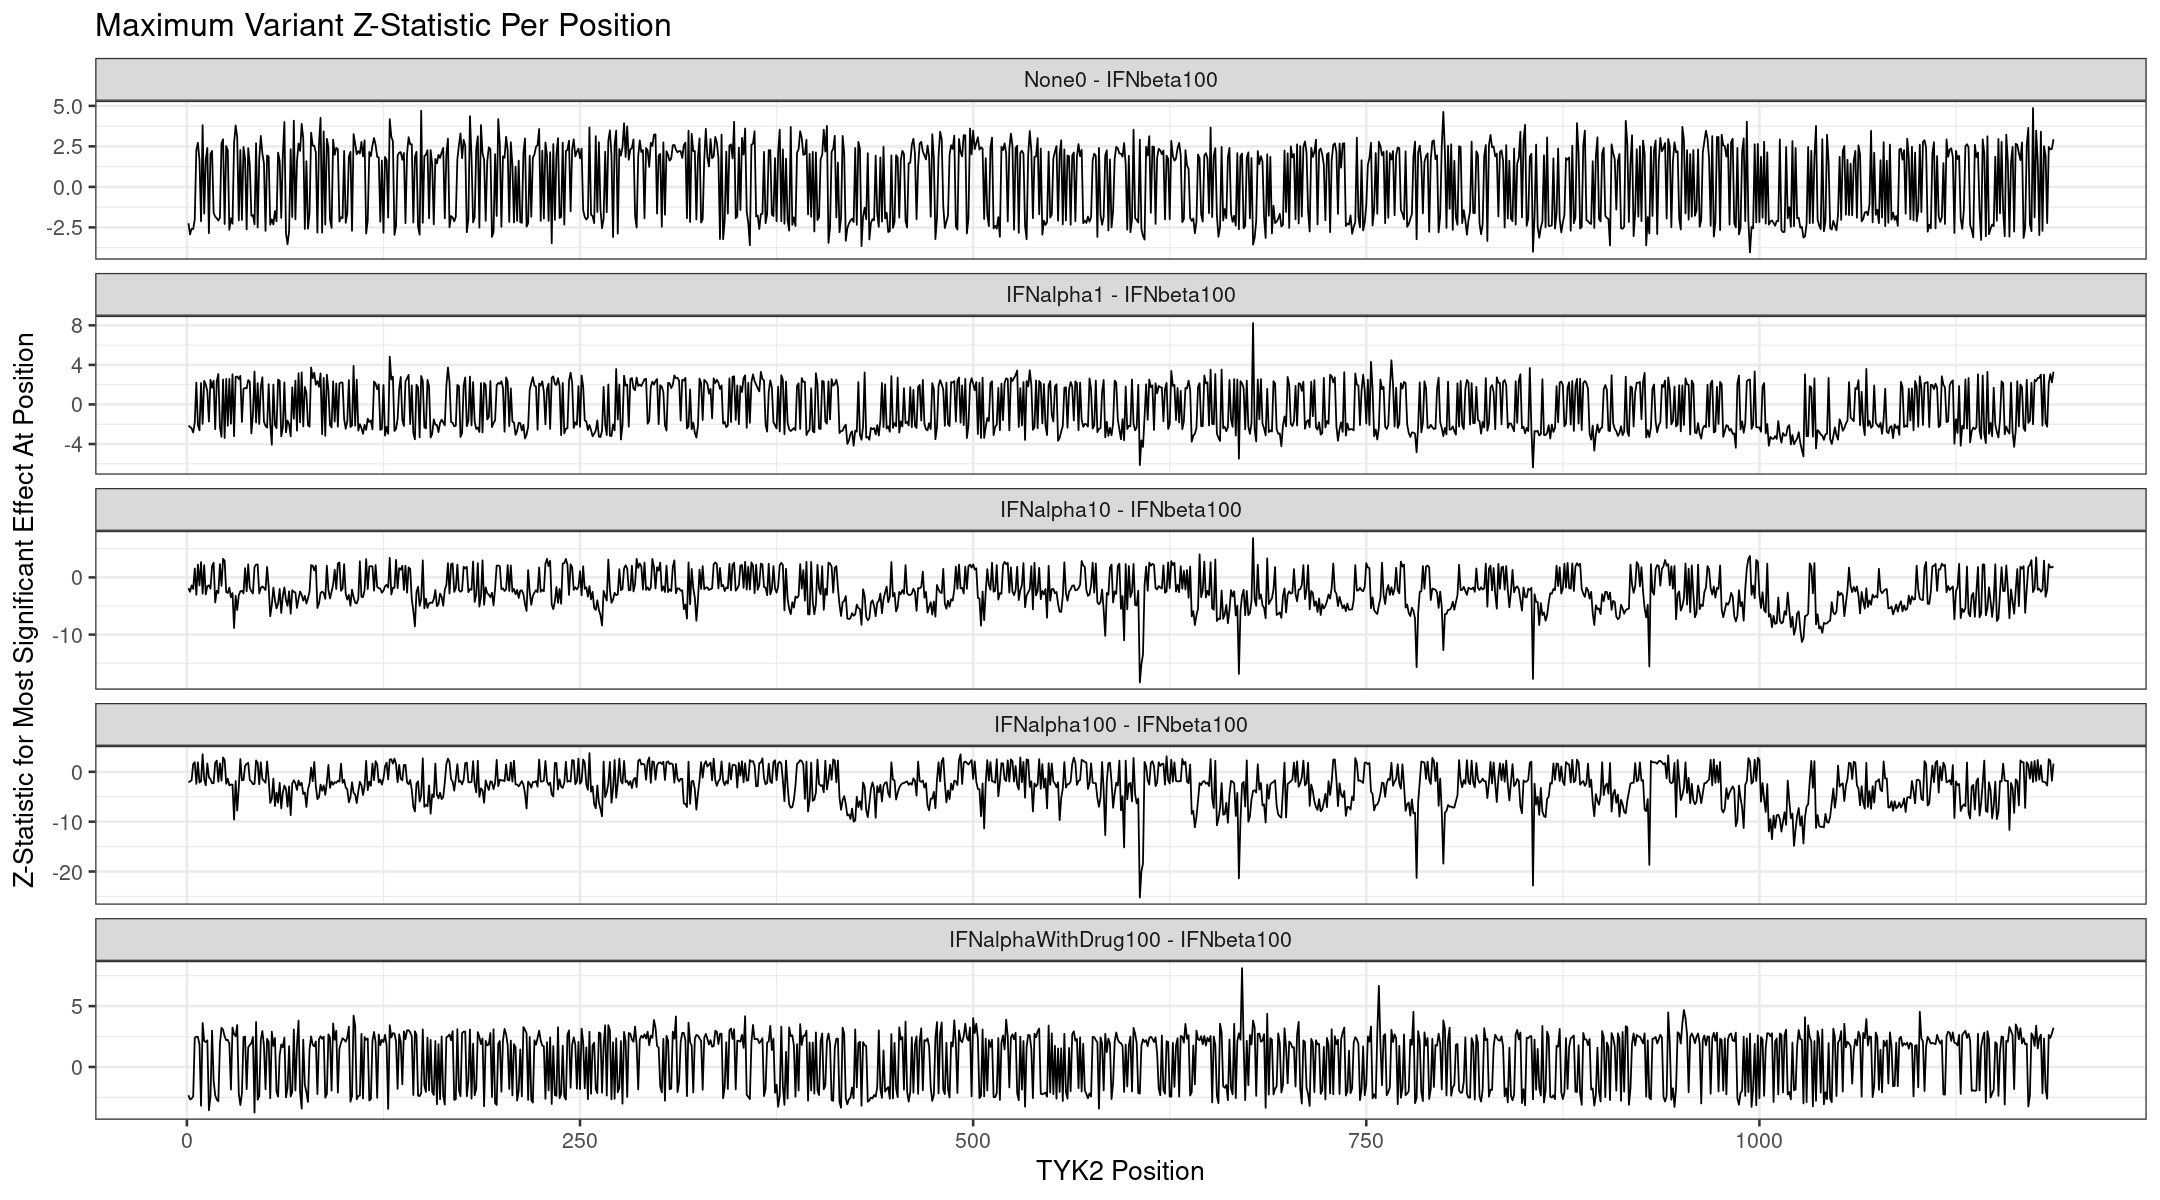

In [40]:
agg1_data_max <-  aggregate_cols(sumstats_all %>% filter(grepl("- None0", condition)), method = "maximum") %>%
    mutate(method = "maximum")
agg2_data_max <-  aggregate_cols(sumstats_all %>% filter(grepl("- IFNbeta100", condition)), method = "maximum") %>%
    mutate(method = "maximum")

agg1 <- ggplot(agg1_data_max) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Most Significant Effect At Position")
agg2<- ggplot(agg2_data_max) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Most Significant Effect At Position")

options(repr.plot.width = 18, repr.plot.height = 10)
agg1 + facet_wrap(~condition, ncol = 1, scales = "free_y") + ggtitle("Maximum Variant Z-Statistic Per Position")
agg2 + facet_wrap(~condition, ncol = 1, scales = "free_y") + ggtitle("Maximum Variant Z-Statistic Per Position")

In [41]:
bind_rows(agg1_data_avg,
          agg2_data_avg,
          agg1_data_avgsig,
          agg2_data_avgsig,
          agg1_data_max,
          agg2_data_max) %>% 
    arrange(method, pos) %>%
    write_tsv("../sumstats/TYK2/run3/tyk2-assay3-AggByPos.tsv")

In [42]:
# Separate agg_data into individual comparisons and methods for DMS team

agg_data <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3-AggByPos.tsv")
conds <- expand_grid(unique(agg_data$condition), unique(agg_data$method))

for(i in 1:nrow(conds)){
    
    cond <- conds[[i,1]]
    meth <- conds[[i,2]]    
    
    condition_id <- gsub(" Aggregated Across Residues", "", cond)
    condition_id <- gsub(" - ", "vs", condition_id)
    
    filename <- paste0("../dataviz/TYK2/tyk2-assay3-AggByPos/", condition_id, "_", meth, ".tsv")

    agg_data %>%
        ungroup() %>%
        filter(condition == cond, method == meth) %>%
        write_tsv(filename)
    
}

Rows: 35610 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): condition, method
dbl (2): pos, statistic

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# Concatenate the two sequencing runs - in the future, concatenate at fastq level

mapped_counts_1 <- fread("../pipeline/OCNT-DMSLIB-1-assay-run3/seq1/tyk2.mapped-counts.tsv")
mapped_counts_2 <- fread("../pipeline/OCNT-DMSLIB-1-assay-run3/seq2/tyk2.mapped-counts.tsv")

mapped_counts_concat <- data.table::rbindlist(list(mapped_counts_1, mapped_counts_2))

mapped_counts_sum <- mapped_counts_concat[ , .(count = sum(count)),
                                          by = .(sample, barcode, oligo, chunk, dox,
                                                 condition, condition_conc, clone)]

write_tsv(mapped_counts_sum,
          "../pipeline/OCNT-DMSLIB-1-assay-run3/tyk2.mapped-counts.tsv")